In [6]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
%pip uninstall -y pandas numpy
%pip install pandas numpy

Found existing installation: pandas 2.3.1
Uninstalling pandas-2.3.1:
  Successfully uninstalled pandas-2.3.1
Note: you may need to restart the kernel to use updated packages.


ERROR: Exception:
Traceback (most recent call last):
  File "c:\Users\olaal\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_internal\cli\base_command.py", line 160, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "c:\Users\olaal\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_internal\commands\uninstall.py", line 103, in run
    uninstall_pathset.commit()
  File "c:\Users\olaal\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_internal\req\req_uninstall.py", line 424, in commit
    self._moved_paths.commit()
  File "c:\Users\olaal\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_internal\req\req_uninstall.py", line 277, in commit
    save_dir.cleanup()
  File "c:\Users\olaal\AppData\Local\Programs\Python\Python311\Lib\site-packages\pip\_internal\utils\temp_dir.py", line 173, in cleanup
    rmtree(self._path)
  File "c:\Users\olaal\AppData\Local\Programs\Python\Python311\Lib\site-packages\pi

  Using cached pandas-2.3.1-cp311-cp311-win_amd64.whl (11.3 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LassoCV, lasso_path, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from patsy import dmatrices
from statsmodels.stats.anova import anova_lm
from group_lasso import GroupLasso
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pathlib import Path

AttributeError: partially initialized module 'pandas' has no attribute '_pandas_datetime_CAPI' (most likely due to a circular import)

### Background
This example studies data from Alabama, Arkansas, Louisiana, and North Carolina, providing healthcare utilization on Medicaid recipients in 2011.  Medicaid is an income based health  insurance program managed by the United States federal government that provided  benefits to around 70 million persons, nationwide.

In this example, we will build multiple models to examine the following questions:

1. What factors impact the healthcare cost due to emergency department encounters?
2. Is access to primary care providers associated with healthcare costs due to emergency department encounters?

Disclaimer: This analysis of healthcare utilization for the Medicaid population using the MAX claims data is in compliance with the study protocol approved by the  Georgia Tech Internal Review Board (IRB) and by CMS. Do NOT use the data  provided for this analysis for purposes other than the study in this lesson. 

### Reading the data

In [ ]:
%python
# Read in the data file from the catalog
dataAdult = spark.table("workspace.data_adult_schema.data_adult").toPandas()
display(dataAdult)

### Data Description
Response Variable:

EDcost: The response variable of interest. Emergency Department cost aggregated at the census tract level

Predictors and Other Variables:

PMPM: Per member per month - Total number of enrollment months aggregated by census tract

State: State of the member

GEOID: Census tract identification number

ED: Number of emergency department claims

HO: Number of hospitalization claims

PO: Number of physician office claims

BlackPop: Example of one of multiple characteristics showing the percentages of Medicaid-enrolled adults of various populations

Unemployment: One of 13 variables quantifying other possibly health-related factors



# Preparing the Data
In the code below, we scale the response variable EDCost and the utilization variables using PMPM to allow for comparison across census tracts. Each census tract has different numbers of enrollees, and each enrollee can have a different length of enrollment. Because of this, scaling EDcost by PMPM allows a comparison of cost per enrollee month.

In [ ]:
# Rescale outcome/response variable
dataAdult['EDCost_pmpm'] = dataAdult['EDCost'] / dataAdult['PMPM']

# Rescale utilization
dataAdult['PO'] = dataAdult['PO'] / dataAdult['PMPM']
dataAdult['HO'] = dataAdult['HO'] / dataAdult['PMPM']

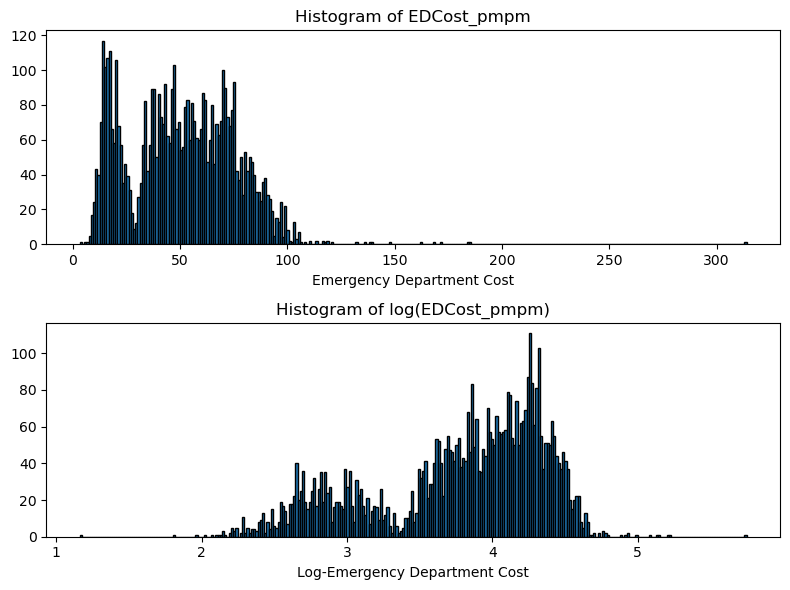

In [ ]:
# Set up the plotting area
plt.figure(figsize=(8, 6))

# Histogram of the response variable
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.hist(dataAdult['EDCost_pmpm'], bins=300, edgecolor='black')
plt.xlabel('Emergency Department Cost')
plt.title('Histogram of EDCost_pmpm')

# Histogram of the logarithm of the response variable
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.hist(np.log(dataAdult['EDCost_pmpm']), bins=300, edgecolor='black')
plt.xlabel('Log-Emergency Department Cost')
plt.title('Histogram of log(EDCost_pmpm)')

# Show the plot
plt.tight_layout()
plt.show()

For histogram of EDCost.pmpm (top one), the shape of the distribution is skewed with the data concentrated into a rather small range. It is an indication that the normality assumption might not hold.

The histogram of the log transformed data is on the bottom. The log transformation performs well in centering the data while spreading the data over a wider range. We also see here that we have two clear modes in the distribution of the response variable after transforming the data. It is our hope that this bimodality will be explained by the predicting variables considered in this study.

In [ ]:
dataAdult['log_EDCost_pmpm'] = np.log(dataAdult['EDCost_pmpm'])

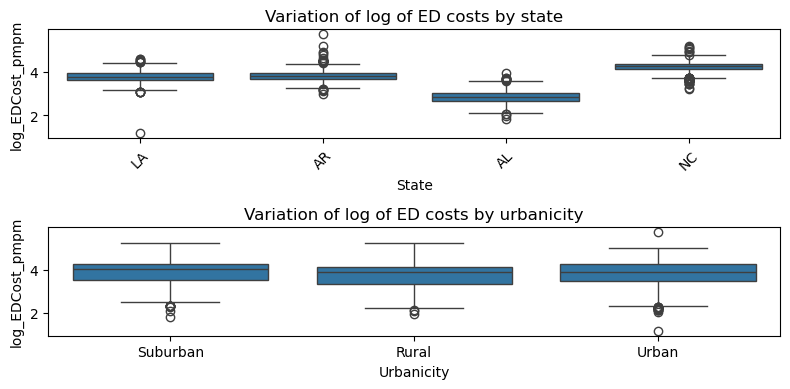

In [ ]:
## Response variable vs categorical predicting variables

# Set up the plotting area
plt.figure(figsize=(8, 4))

# Boxplot for log.EDCost.pmpm by State
plt.subplot(2, 1, 1)
sns.boxplot(x='State', y='log_EDCost_pmpm', data=dataAdult)
plt.title('Variation of log of ED costs by state')
plt.xticks(rotation=45)  # Rotates the X-axis labels for better readability

# Boxplot for log.EDCost.pmpm by Urbanicity
plt.subplot(2, 1, 2)
sns.boxplot(x='Urbanicity', y='log_EDCost_pmpm', data=dataAdult)
plt.title('Variation of log of ED costs by urbanicity')

# Show the plot
plt.tight_layout()
plt.show()

We use side-by-side box plots to assess the relationship between the response variable and the qualitative predicting variables.

When comparing the EDCost.pmpm across states, we see clear differences in the medians, with North Carolina having the higher median and Alabama having the lowest median. 

The differences among the medians across the three different urbanicity levels (rural, suburban, and urban) are not strikingly different. 

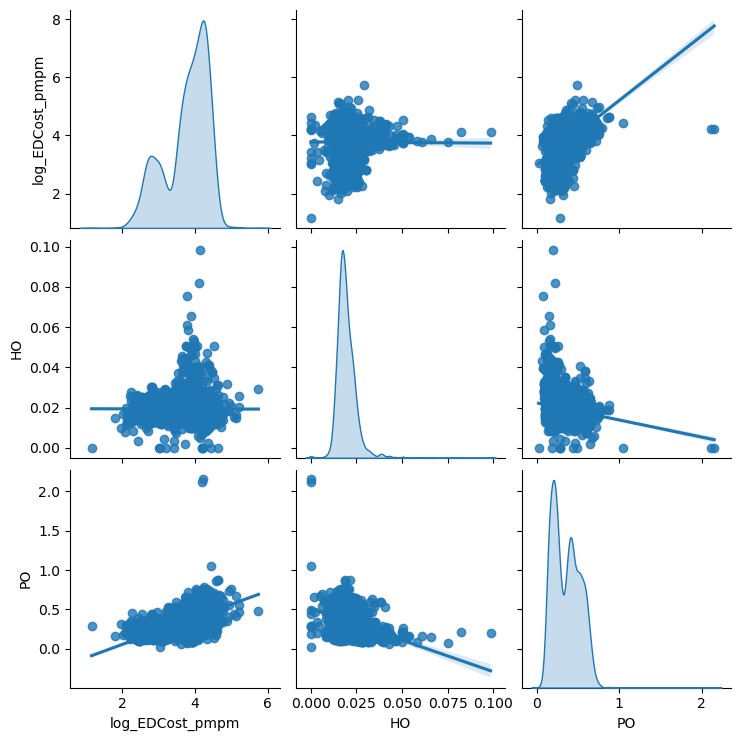

In [ ]:
## Response vs Utilization

# Create the scatter plot matrix
sns.pairplot(dataAdult[['log_EDCost_pmpm', 'HO', 'PO']], kind = 'reg', diag_kind='kde', height=2.5)

# Show the plot
plt.show()

We use matrix plot to explore the relationsip between the response and quantative predictive variables.

There is strong positive correlation between the ED cost and the utilization of physician office, but not a strong relationship with in-patient care utilization. Moreover, there is only a weak correlation between the utilization of physician office and in-patient utilization.

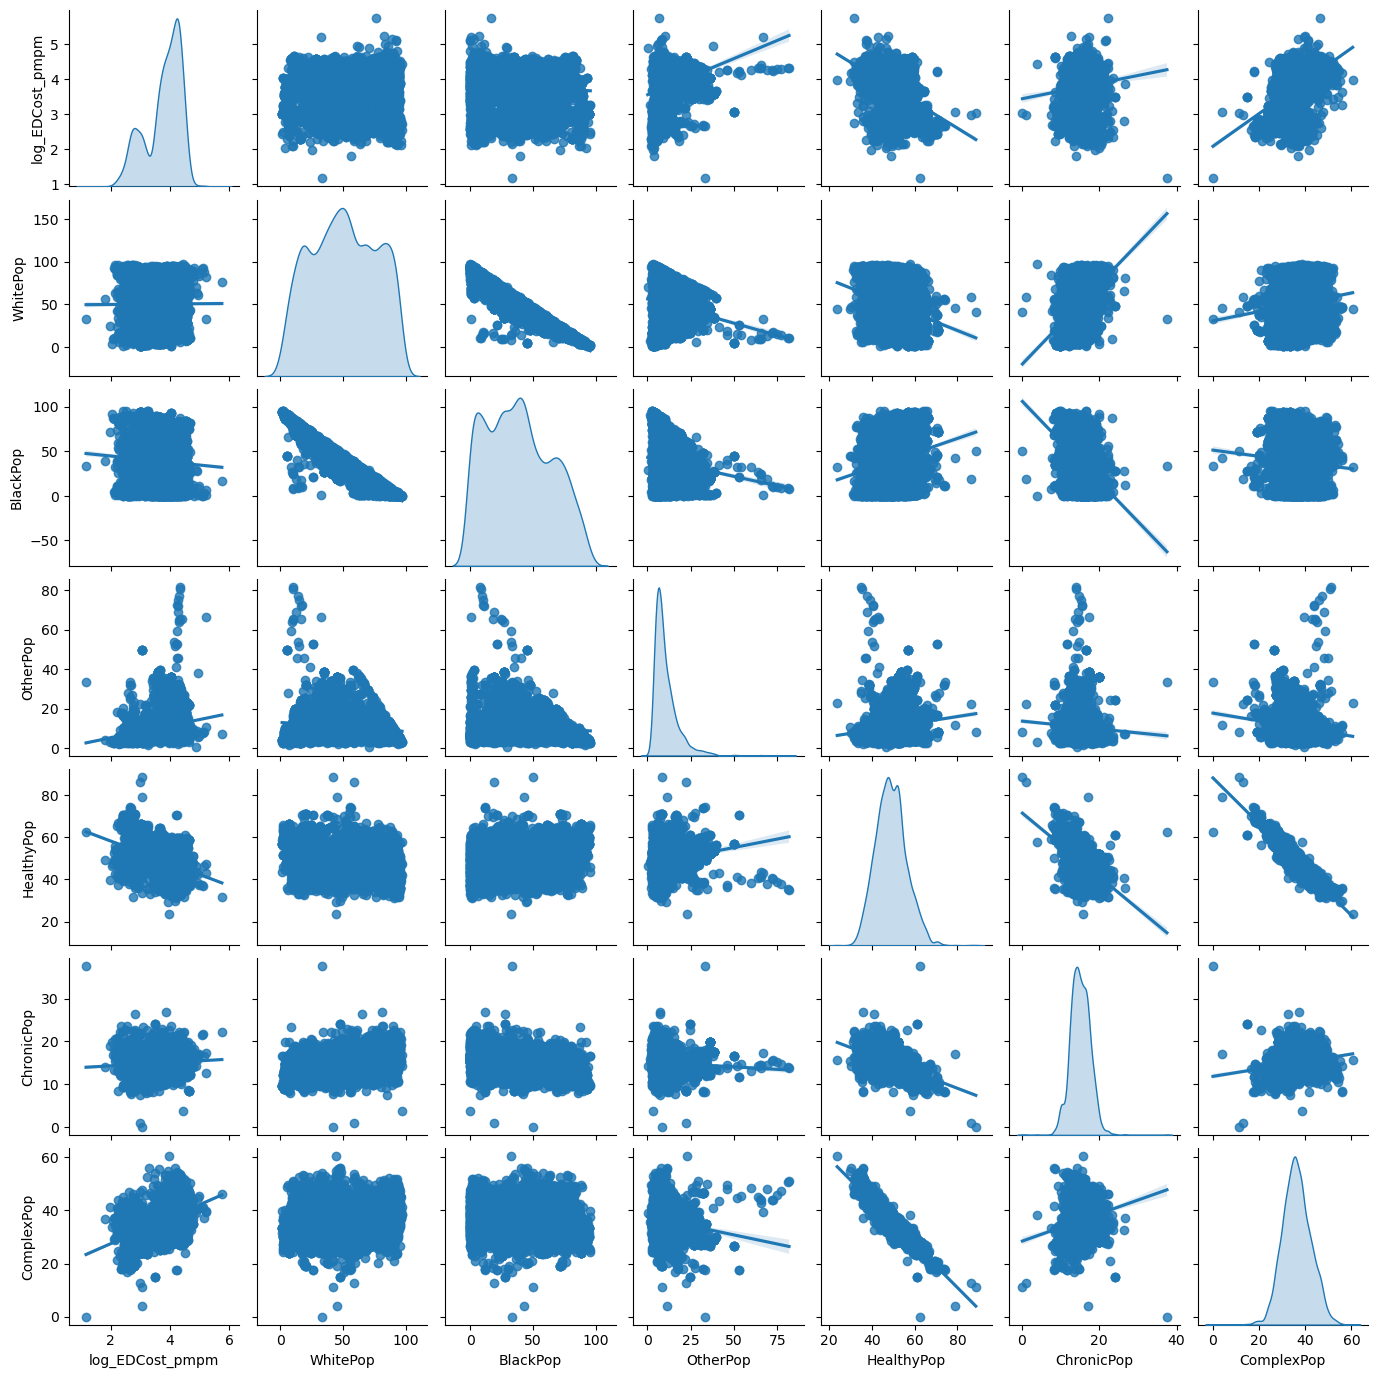

In [ ]:
## Response vs Population Characteristics

# Create the scatter plot matrix
sns.pairplot(dataAdult[['log_EDCost_pmpm', 'WhitePop', 'BlackPop', 'OtherPop', 'HealthyPop', 'ChronicPop', 'ComplexPop']], kind = 'reg', diag_kind='kde',height = 2.0)

# Show the plot
plt.show()

This matrix plot is for population characteristics, with six population categories to consider.

There is a weak relationship of the response with respect to black and white population percentages. There is also a negative relationship with the percentage of adults that are considered healthy, a weak positive relationship with the percentage of adults with chronic conditions. Strong positive relationship with a percentage of population with complex conditions. Moreover, there's a strong negative relationship between percentage of black population and percentage of white population.

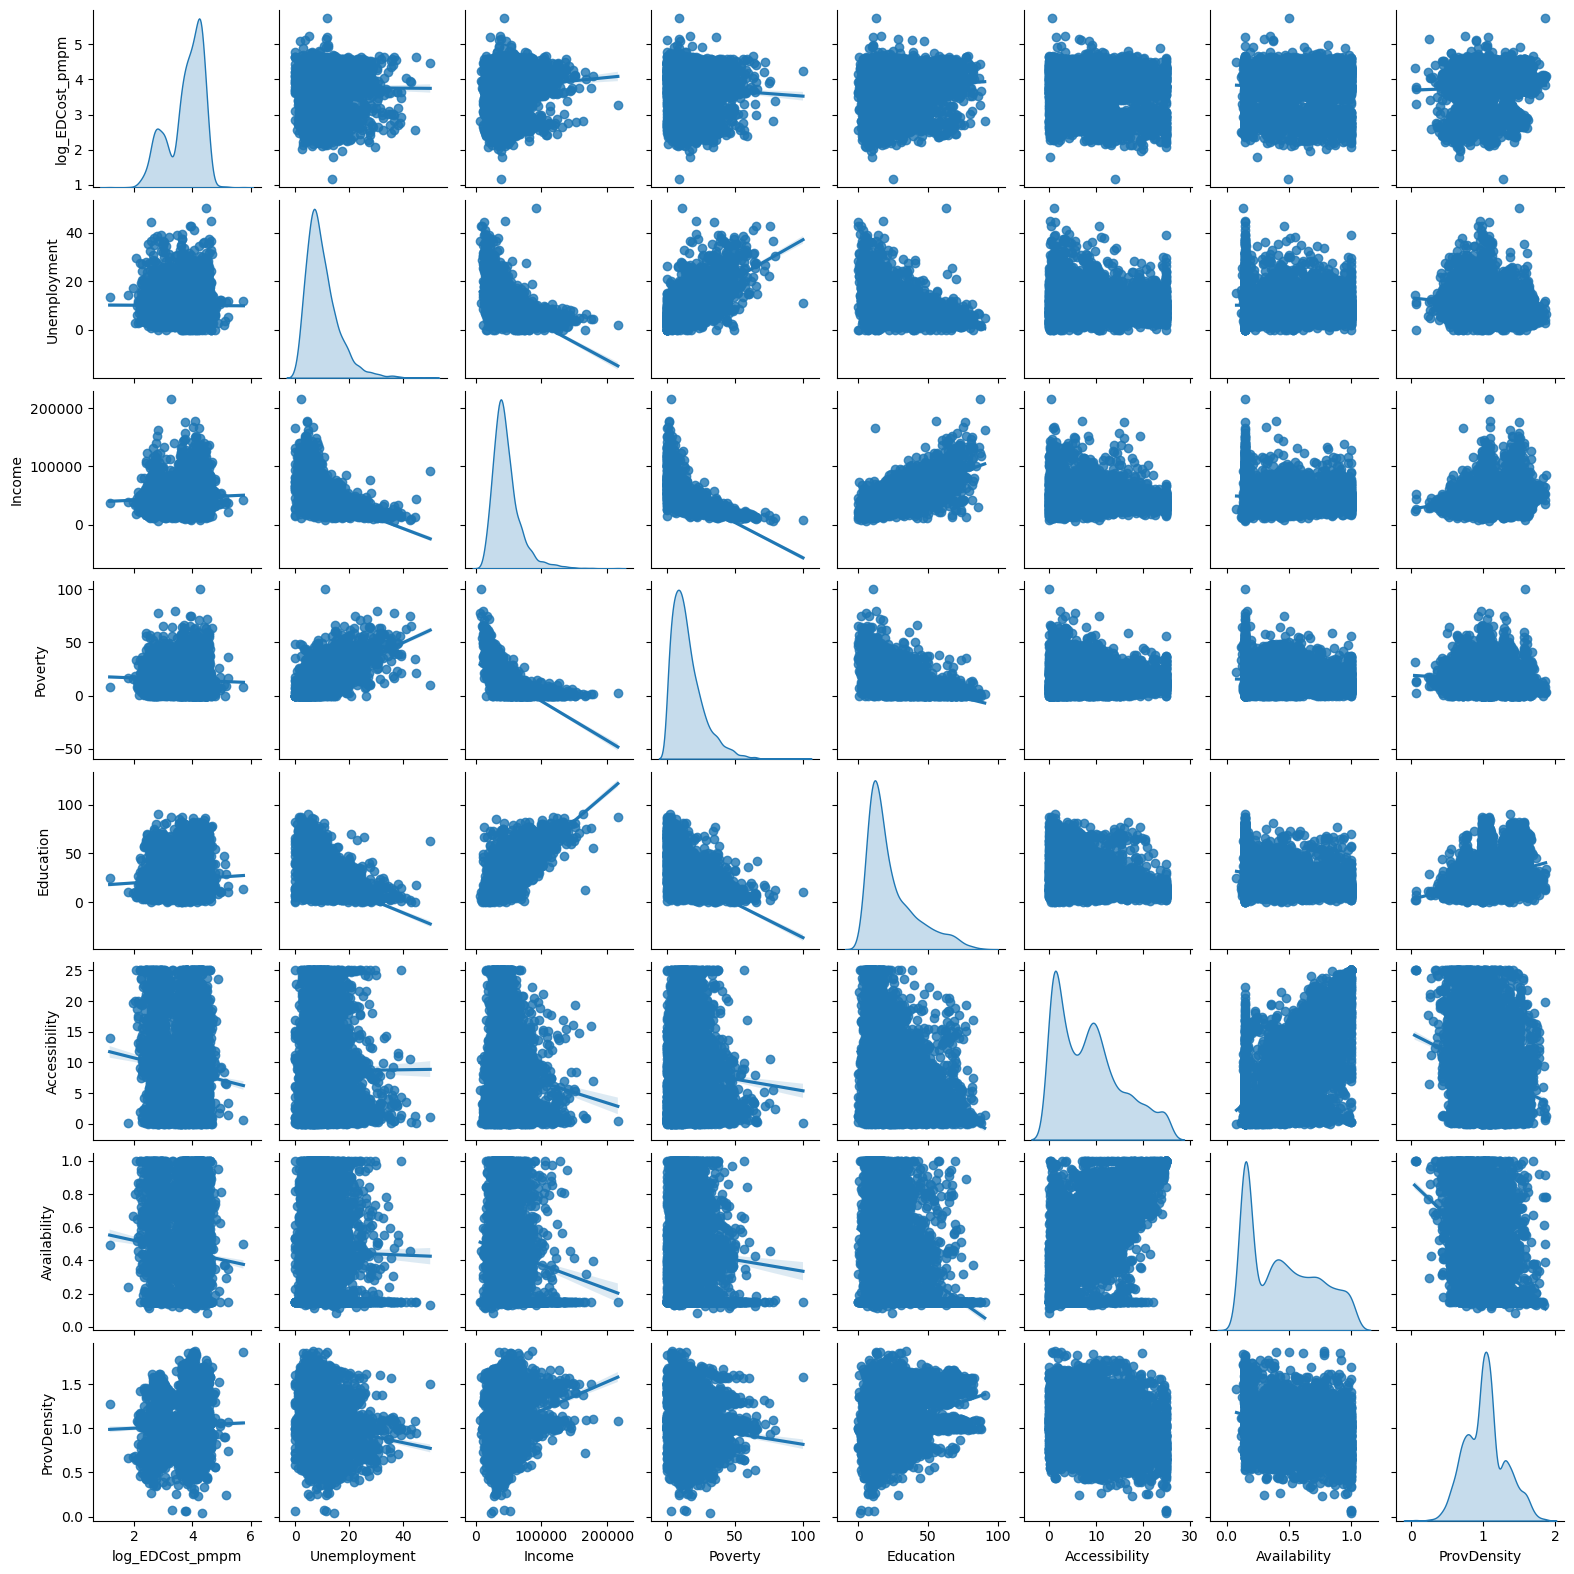

In [ ]:
## Response vs Socioeconomic and Environmental Characteristics

# Create the scatter plot matrix
sns.pairplot(dataAdult[['log_EDCost_pmpm', 'Unemployment', 'Income', 'Poverty', 'Education', 'Accessibility', 'Availability', 'ProvDensity']], kind = 'reg', diag_kind='kde', height=2.0)

# Show the plot
plt.show()

There's no obvious correlation between response variables and socioeconomic and environmental characteristics. A weak negative correlation is observed between reponse and income. 

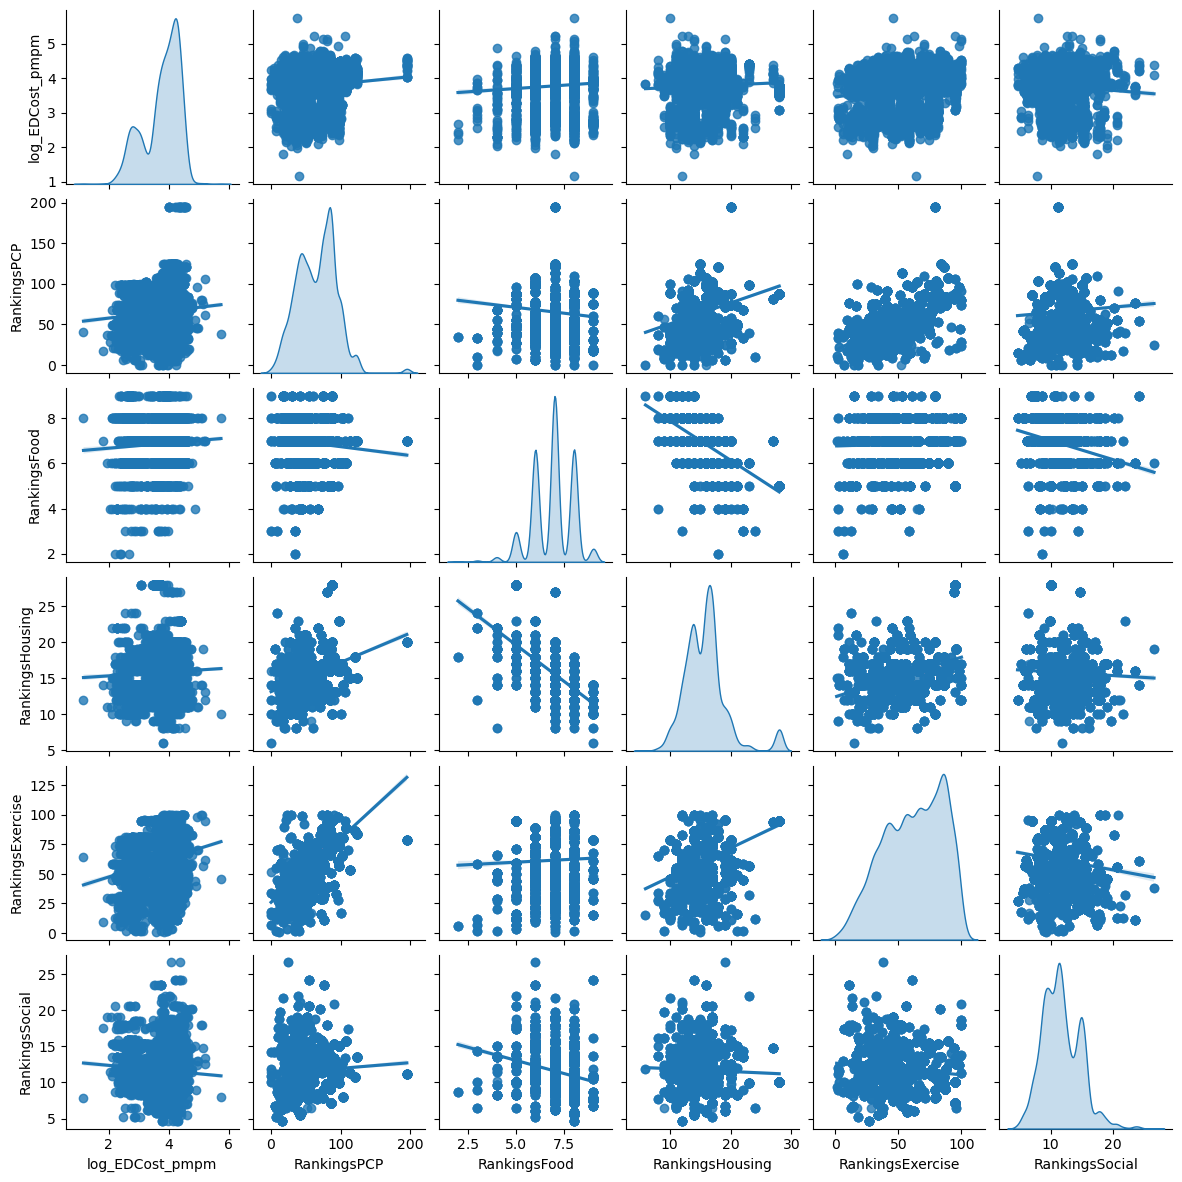

In [ ]:
## Response vs County Health Rankings

# Create the scatter plot matrix
sns.pairplot(dataAdult[['log_EDCost_pmpm', 'RankingsPCP', 'RankingsFood', 'RankingsHousing', 'RankingsExercise', 'RankingsSocial']], kind = 'reg', diag_kind='kde', height=2.0)

# Show the plot
plt.show()

A mild positive correlation can be observed between reponse variable and RankingExercise.

### Correlation matrix plot

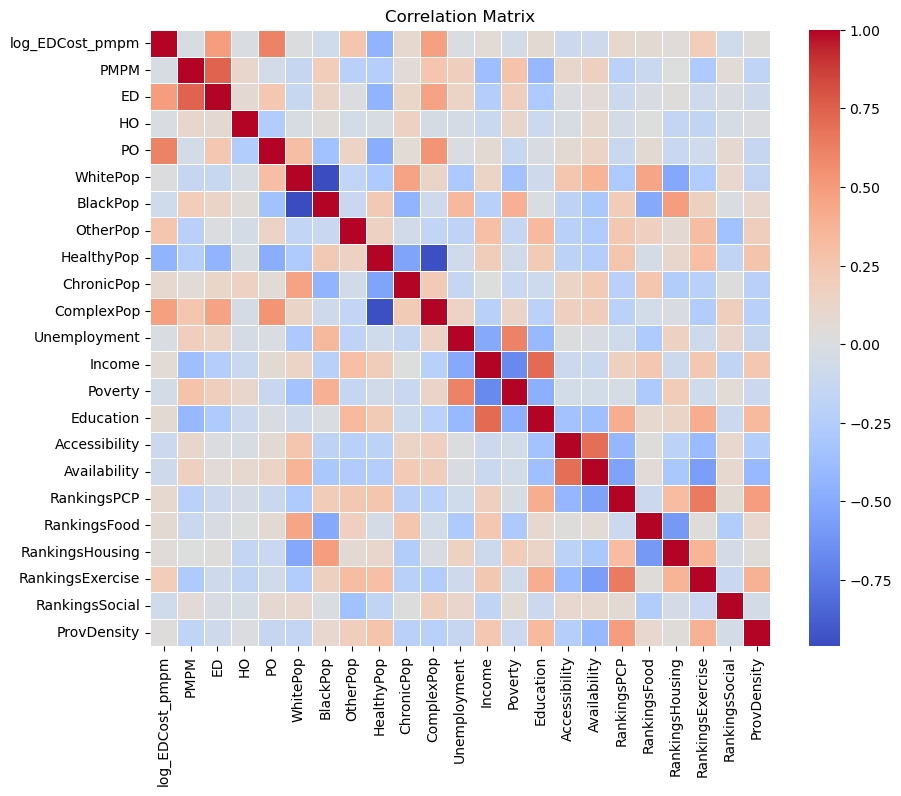

In [ ]:
# Selecting the columns for the correlation matrix
columns_for_corr = ['log_EDCost_pmpm'] + list(dataAdult.columns[3:17]) + list(dataAdult.columns[18:26])
corr_data = dataAdult[columns_for_corr]

# Calculate the correlation matrix
corr_matrix = corr_data.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')

# Show the plot
plt.show()

We can see a large positive correlation between the response variable and the utilization of physician office and a large positive correlation between the response variable and the percentage of adults with complex conditions. We also see a large negative correlation between the response variable and the percentage of population that are considered healthy.

Among the predicting variables, we see a strong negative correlation between the percentage of black and percentage of white populations, and between percentage of adults that are considered healthy and percentage of adults with complex conditions. 

### Full Model

In [ ]:
## Exclude GEOID, scaling factor PMPM, and confounding factors EDCost and ED
## Exclude OtherPop & ComplexPop because of linear dependence
dataAdult_red = dataAdult.drop(['GEOID', 'PMPM', 'EDCost', 'ED', 'EDCost_pmpm', 'OtherPop', 'ComplexPop'], axis = 1)

# Convert categorical variables to dummy variables (one-hot encoding)
# Specify drop_first=True to avoid multicollinearity issues
dataAdult_red = pd.get_dummies(dataAdult_red, drop_first=True)

# Ensure all data is numeric
dataAdult_red = dataAdult_red.apply(pd.to_numeric, errors='coerce')
dataAdult_red['State_AR'] = dataAdult_red['State_AR'].astype(int)
dataAdult_red['State_LA'] = dataAdult_red['State_LA'].astype(int)
dataAdult_red['State_NC'] = dataAdult_red['State_NC'].astype(int)
dataAdult_red['Urbanicity_Suburban'] = dataAdult_red['Urbanicity_Suburban'].astype(int)
dataAdult_red['Urbanicity_Urban'] = dataAdult_red['Urbanicity_Urban'].astype(int)

# Fitting the full model
X = dataAdult_red.drop('log_EDCost_pmpm', axis=1)
y = dataAdult_red['log_EDCost_pmpm']
X = sm.add_constant(X)  # Adds a constant term to the predictor
fullmodel = sm.OLS(y, X).fit()

# Display the summary of the model
print(fullmodel.summary())

                            OLS Regression Results                            
Dep. Variable:        log_EDCost_pmpm   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     1218.
Date:                Thu, 22 May 2025   Prob (F-statistic):               0.00
Time:                        22:48:04   Log-Likelihood:                 221.99
No. Observations:                5019   AIC:                            -396.0
Df Residuals:                    4995   BIC:                            -239.5
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.2075    

To fit the regression model, we will need to discard the GEOID, the PMPM scaling factor, the ED utilization, which is a confounding factor, and the percentage of Other population due to the linear dependence with the black and white population percentages. We also need to discard population percentages with complex health conditions due to the linear dependence with the percentage of adults with chronic conditions and of those who are relatively healthy. 

Regarding the full model, socioeconomic predicting variables including unemployment, median income, percentage of population below the poverty level, and rankings with respect to social environment, are not statistically significant given other predicting variables in the model.

The predicting variables included in the model explain approximately 84% of the variability in the reponse variable which is a large R squared for an observational study.

In [ ]:
# Residual Analysis
influence = fullmodel.get_influence()

# Calculate standardized residuals
full_resid = influence.resid_studentized_internal
# Calculate Cook's distance
cooks_d, pvals = influence.cooks_distance

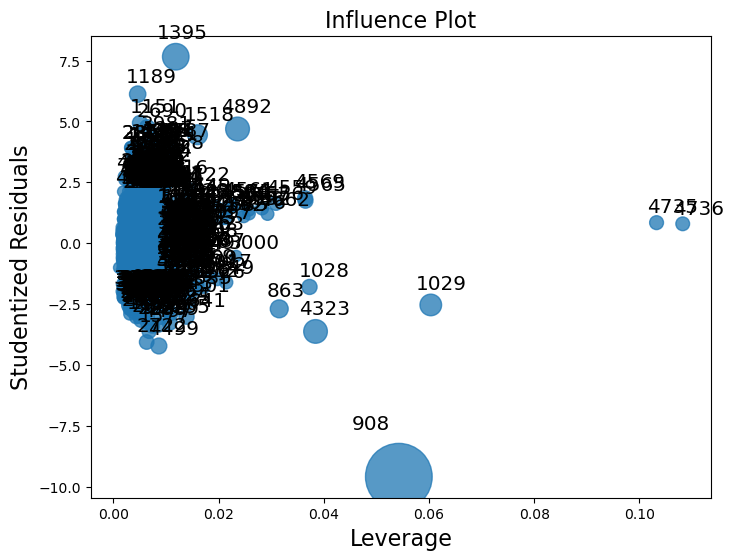

In [ ]:
#Check outliers

# Create an influence plot
fig, ax = plt.subplots(figsize=(8,6))
sm.graphics.influence_plot(fullmodel, ax=ax, criterion="cooks")

# Show the plot
plt.show()

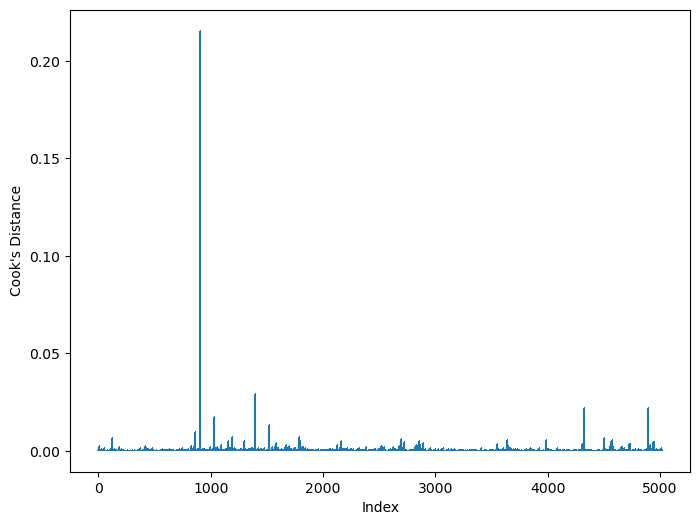

In [ ]:
# Plot Cook's distance
plt.figure(figsize=(8, 6))
plt.stem(cooks_d, linefmt='-', markerfmt=',', basefmt=" ")
plt.xlabel('Index')
plt.ylabel("Cook's Distance")
plt.show()

The influence plot which creates a bubble plot of the standardized residuals with areas of the circles being proportional to Cook’s distances. Both plots clearly show that point 908 is an outlier.

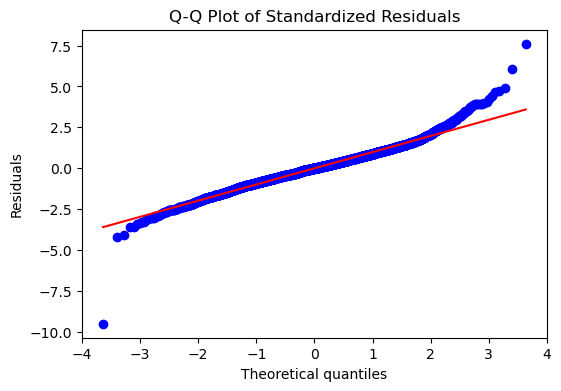

In [ ]:
## Check Normality
# Generate a Q-Q plot
plt.figure(figsize=(6, 4))
stats.probplot(full_resid, dist="norm", plot=plt)
plt.title("Q-Q Plot of Standardized Residuals")
plt.ylabel("Residuals")
plt.show()

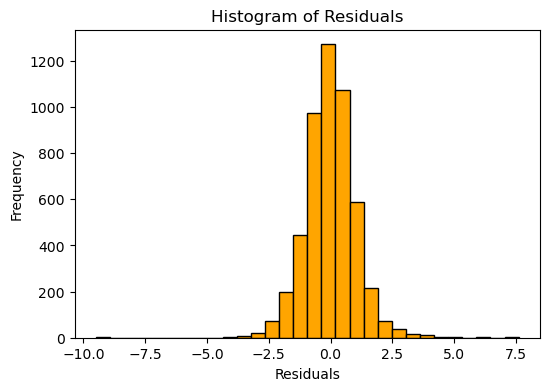

In [ ]:
# Plot histogram of residuals
plt.figure(figsize=(6, 4))
plt.hist(full_resid, bins=30, color='orange', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

The distribution of the residuals is symmetric but with heavy tails, possibly, more of a T distribution than a normal distribution.

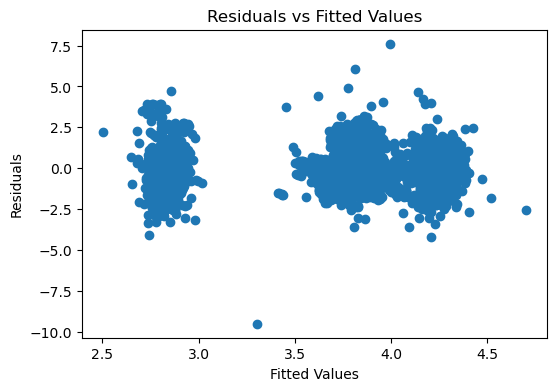

In [ ]:
## Check Constant Variance & Uncorrelated Errors
# Calculate fitted values
full_fitted = fullmodel.fittedvalues

# Plot residuals against fitted values
plt.figure(figsize=(6, 4))
plt.scatter(full_fitted, full_resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

We evaluate the assumptions of constant variance and uncorrelated errors. There is no evidence that the variance changes across the residuals. However, there are three clear clusters of the residuals pointing out to a possible departure from the uncorrelated errors assumption. 

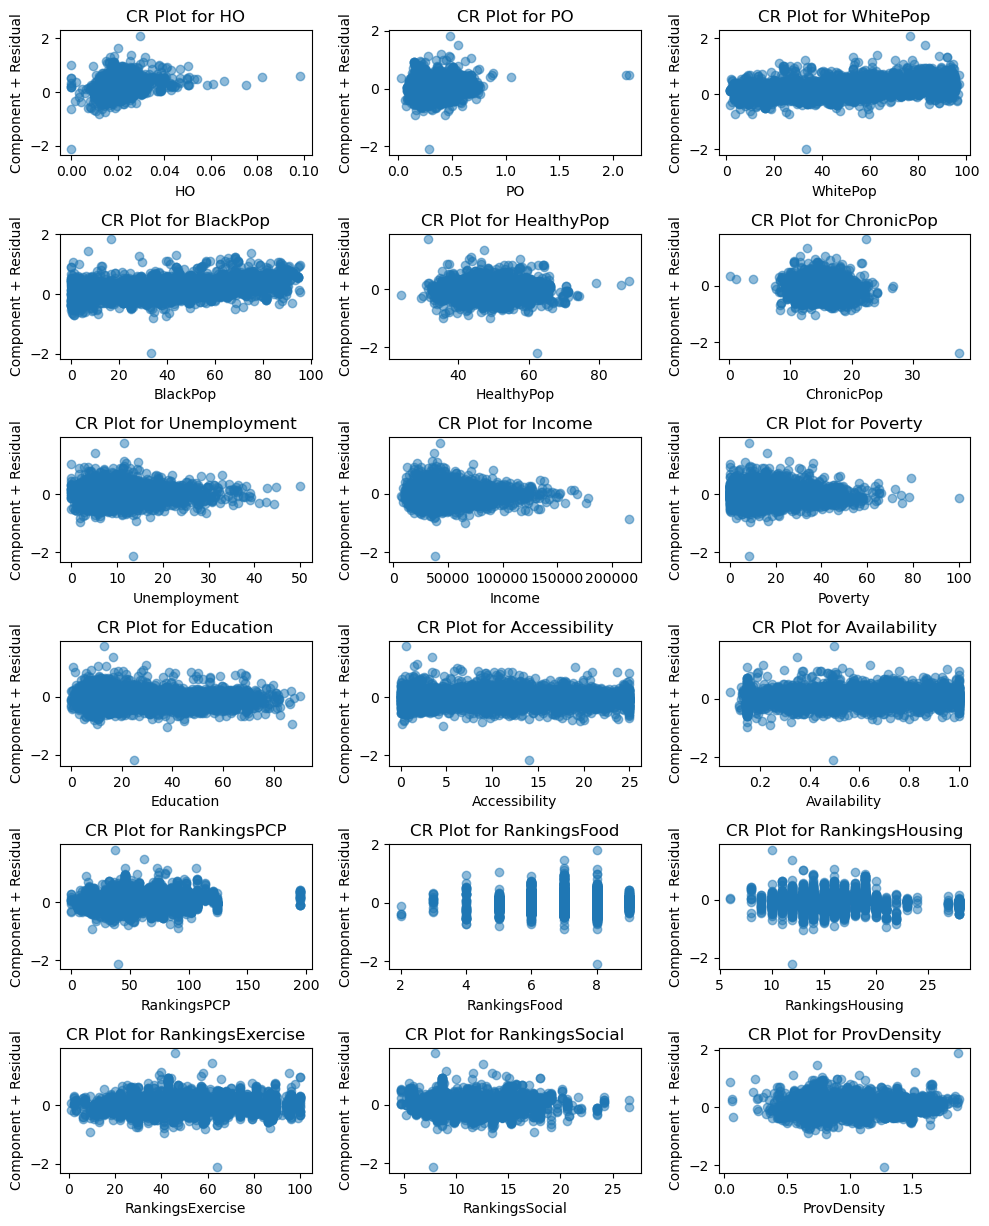

In [ ]:
## Check Linearity

# Get predictor variable names, excluding the intercept and categorical predictors
predictor_vars = [var for var in fullmodel.model.exog_names if var not in ['const', 'State_AR', 'State_LA', 'State_NC', 'Urbanicity_Urban', 'Urbanicity_Suburban']]

# Number of rows and columns for subplots
n = len(fullmodel.model.exog_names)
ncols = 3
nrows = n // ncols + (n % ncols > 0)

# Create subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 2 * nrows))
axs = axs.flatten()  # Flatten to 1D array for easy indexing

# Generate CR Plot for each predictor
for i, var in enumerate(predictor_vars):
    # Calculate component plus residual values
    exog_idx = fullmodel.model.exog_names.index(var)
    partial_resid = fullmodel.resid + fullmodel.model.exog[:, exog_idx] * fullmodel.params[var]

    # Plot
    axs[i].scatter(fullmodel.model.exog[:, exog_idx], partial_resid, alpha=0.5)
    axs[i].set_xlabel(var)
    axs[i].set_ylabel('Component + Residual')
    axs[i].set_title(f'CR Plot for {var}')

# Hide unused subplots if any
for j in range(i + 1, nrows * ncols):
    axs[j].set_visible(False)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

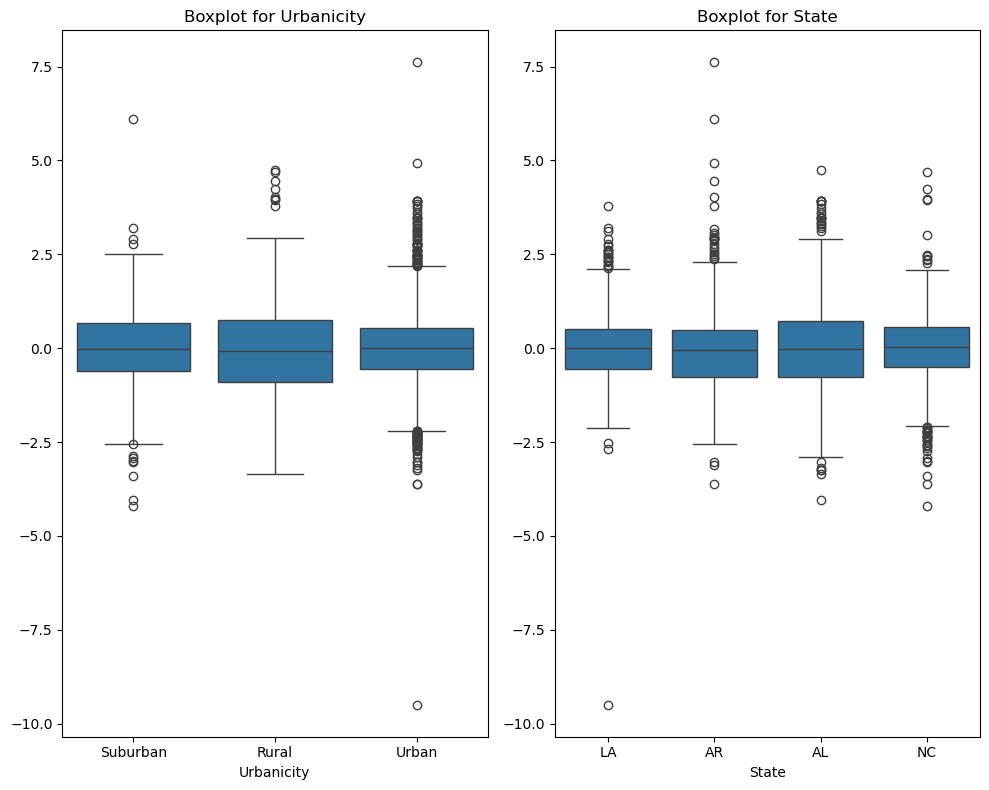

In [ ]:
# Now, plot the boxplots for 'Urbanicity' and 'State'
fig, axs = plt.subplots(1, 2, figsize=(10, 8))

# Boxplot for 'Urbanicity'
sns.boxplot(x= dataAdult['Urbanicity'], y= full_resid, ax=axs[0])
axs[0].set_title('Boxplot for Urbanicity')

# Boxplot for 'State'
sns.boxplot(x= dataAdult['State'], y= full_resid, ax=axs[1])
axs[1].set_title('Boxplot for State')

# Show the plots
plt.tight_layout()
plt.show()

This step is to check the linearity. We use boxplots for qualitative variables and scatterplots for quantitative variables.

Interpretation:
The boxplot of residuals vs. state shows some variation across the states but small variation among medians.

The scatterplot of hospitalization vs. residuals shows a slight increase in the trend, possibly due to the fact that there are a few large values in the inpatient utilization that pull the trend upwards. 

### VARIABLE SELECTION
Because we have 23 predictors, we also have 2^23 = 8388608 possible models thus not feasible to compare all models. We will next apply regularized regression for model selection.



## Apply Lasso

In [ ]:
X = dataAdult_red.drop(['log_EDCost_pmpm'], axis = 1)
X = pd.get_dummies(X, drop_first = True)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Response variable
y = dataAdult_red['log_EDCost_pmpm']

# Set up the LASSO model with cross-validation
lasso_cv = LassoCV(alphas=None, cv=10, n_alphas=100, max_iter=10000)

# Fit the model
lasso_cv.fit(X_scaled, y)
alphas, coefs, _ = lasso_path(X_scaled, y, n_alphas=100)


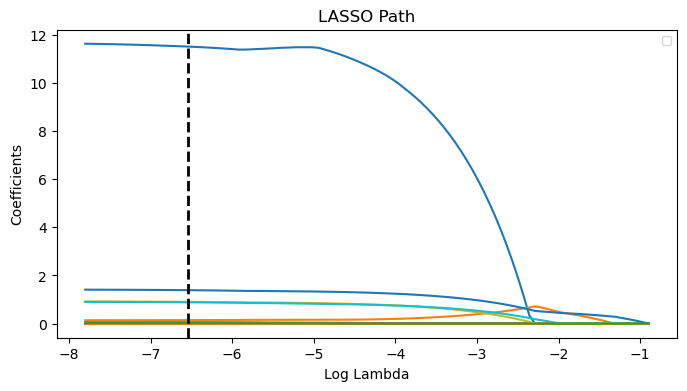

In [ ]:
# Plot coefficient paths
plt.figure(figsize=(8, 4))
plt.plot(np.log(alphas), coefs.T/scaler.scale_)
plt.axvline(np.log(lasso_cv.alpha_), color='black', linestyle='--', linewidth=2)
plt.xlabel('Log Lambda')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.legend(loc='best', fontsize='small')
plt.show()

The vertical line in the path plot corresponds to the optimal lambdas, suggesting the selection of 20 out of 23 predicting variables.

Among the coefficient paths that stand out, the blue line corresponds to the first variable in the matrix of the predicting variables, which corresponds to number of hospitalization claims. Urbanicity dummy variables were selected but have low coefficient paths. 

In [ ]:
# Extract standard deviations of the scaled features
stds = scaler.scale_

# Rescale coefficients (except the intercept)
rescaled_coefs = lasso_cv.coef_ / stds

# Convert rescaled coefficients to a pandas Series to match the original feature names
rescaled_coefs_series = pd.Series(rescaled_coefs, index=X.columns)

# Print the rescaled coefficients
print("Intercept \t", lasso_cv.intercept_)
print(rescaled_coefs_series)

Intercept 	 3.7707151128008647
HO                     1.151378e+01
PO                     1.450487e-01
WhitePop               2.214846e-03
BlackPop               2.687123e-03
HealthyPop            -1.324848e-03
ChronicPop            -4.676396e-03
Unemployment           5.570737e-05
Income                -1.667364e-07
Poverty               -0.000000e+00
Education             -1.447121e-03
Accessibility         -1.320239e-03
Availability           6.055374e-02
RankingsPCP            6.297467e-04
RankingsFood           3.181621e-03
RankingsHousing       -4.257114e-03
RankingsExercise       3.663758e-04
RankingsSocial         0.000000e+00
ProvDensity            5.521336e-02
State_AR               9.024164e-01
State_LA               8.843840e-01
State_NC               1.389153e+00
Urbanicity_Suburban   -0.000000e+00
Urbanicity_Urban       1.901267e-02
dtype: float64


Python's Lasso has eliminated the following extra variables: Poverty, Urbanicity_Suburban, RankingsSocial.
20 out of 23 predicting variables are selected at the optimal lambda.

### Apply Elastic Net

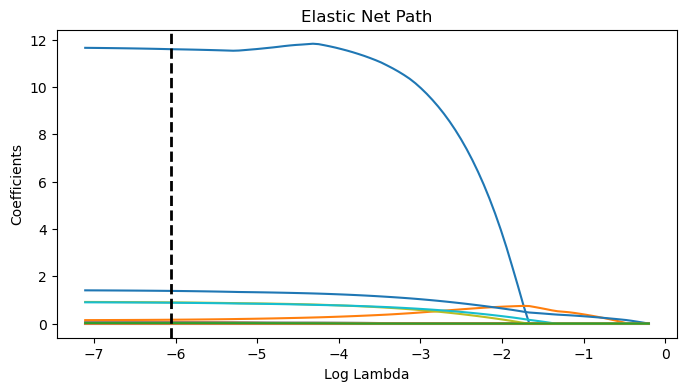

In [ ]:
# Set up the Elastic Net model with cross-validation
enet_cv = ElasticNetCV(l1_ratio=0.5, alphas=None, cv=10, n_alphas=100, max_iter=10000)

# Fit the model
enet_cv.fit(X_scaled, y)
alphas, coefs, _ = enet_cv.path(X_scaled, y)

# Plot coefficient paths
plt.figure(figsize=(8, 4))
plt.plot(np.log(alphas), coefs.T/scaler.scale_)
plt.axvline(np.log(enet_cv.alpha_), color='black', linestyle='--', linewidth=2)
plt.xlabel('Log Lambda')
plt.ylabel('Coefficients')
plt.title('Elastic Net Path')
plt.show()

High coefficients paths are similar to those for LASSO. 

In [ ]:
# Rescale coefficients (except the intercept)
rescaled_coefs = enet_cv.coef_ / stds

# Convert rescaled coefficients to a pandas Series to match the original feature names
rescaled_coefs_series = pd.Series(rescaled_coefs, index=X.columns)

# Print the rescaled coefficients
print("Intercept \t", enet_cv.intercept_)
print(rescaled_coefs_series)

Intercept 	 3.7707151128008647
HO                     1.159258e+01
PO                     1.627647e-01
WhitePop               2.373312e-03
BlackPop               2.864889e-03
HealthyPop            -1.520686e-03
ChronicPop            -5.003369e-03
Unemployment           7.754357e-05
Income                -1.674002e-07
Poverty               -4.961535e-07
Education             -1.440831e-03
Accessibility         -1.468299e-03
Availability           6.477879e-02
RankingsPCP            6.373408e-04
RankingsFood           3.640335e-03
RankingsHousing       -4.355084e-03
RankingsExercise       4.334152e-04
RankingsSocial         0.000000e+00
ProvDensity            5.663237e-02
State_AR               8.958860e-01
State_LA               8.814937e-01
State_NC               1.380716e+00
Urbanicity_Suburban   -0.000000e+00
Urbanicity_Urban       1.984270e-02
dtype: float64


Python's Elastic Net has eliminated the following extra variables: Urbanicity_Suburban, RankingsSocial.
We select 21 variables out of 23 with RankingsSocial being discarded from the model.

# Apply Stepwise Regression

## Forward

In [ ]:
def forward_selection(response, predictors, min_X=None, max_X=None):
    initial_features = predictors.columns.tolist()
    best_features = []
    ic_history = []
    current_ic = np.inf

    if max_X:
      initial_features = max_X

    # Initialize the model with min_X if provided
    if min_X:
        best_features = min_X
        initial_features = [feature for feature in initial_features if feature not in best_features]

    while len(initial_features) > 0:
        ic_with_candidates = []
        for feature in initial_features:
            features_to_test = best_features + [feature]
            tested_model = sm.OLS(response, sm.add_constant(predictors[features_to_test])).fit()
            ic_with_candidates.append((tested_model.aic, feature))

        ic_with_candidates.sort()
        best_ic, best_feature = ic_with_candidates[0]

        if best_ic < current_ic:
            current_ic = best_ic
            best_features.append(best_feature)
            initial_features.remove(best_feature)
            ic_history.append(best_ic)
        else:
            print("Final Selected Features: ", best_features, "\t AIC:", best_ic)
            break
        print("Selected Features so far: ", best_features, "\t AIC:", best_ic)

    return best_features, ic_history

In [ ]:
# Define the response variable
full_formula = "log_EDCost_pmpm ~ HealthyPop + ChronicPop + State_AR + State_LA + State_NC + Urbanicity_Urban + Urbanicity_Suburban + HO + PO + BlackPop + WhitePop + Unemployment + Income + Poverty + Education + Accessibility + Availability + ProvDensity + RankingsPCP + RankingsFood + RankingsExercise + RankingsSocial"

# Create the design matrix
y, X = dmatrices(full_formula, data=dataAdult_red, return_type='dataframe')

In [ ]:
forward_features, _ = forward_selection(y, X, min_X=["Intercept", "HealthyPop", "ChronicPop"], max_X=None)

Selected Features so far:  ['Intercept', 'HealthyPop', 'ChronicPop', 'State_NC'] 	 AIC: 5503.076153149224
Selected Features so far:  ['Intercept', 'HealthyPop', 'ChronicPop', 'State_NC', 'State_LA'] 	 AIC: 4161.2777533926455
Selected Features so far:  ['Intercept', 'HealthyPop', 'ChronicPop', 'State_NC', 'State_LA', 'State_AR'] 	 AIC: 82.49470864729483
Selected Features so far:  ['Intercept', 'HealthyPop', 'ChronicPop', 'State_NC', 'State_LA', 'State_AR', 'HO'] 	 AIC: -196.35628014025315
Selected Features so far:  ['Intercept', 'HealthyPop', 'ChronicPop', 'State_NC', 'State_LA', 'State_AR', 'HO', 'Education'] 	 AIC: -239.74011693375542
Selected Features so far:  ['Intercept', 'HealthyPop', 'ChronicPop', 'State_NC', 'State_LA', 'State_AR', 'HO', 'Education', 'ProvDensity'] 	 AIC: -279.0924761318438
Selected Features so far:  ['Intercept', 'HealthyPop', 'ChronicPop', 'State_NC', 'State_LA', 'State_AR', 'HO', 'Education', 'ProvDensity', 'RankingsPCP'] 	 AIC: -290.3764967687039
Selected Fe

In [ ]:
forward_features

['Intercept',
 'HealthyPop',
 'ChronicPop',
 'State_NC',
 'State_LA',
 'State_AR',
 'HO',
 'Education',
 'ProvDensity',
 'RankingsPCP',
 'Availability',
 'Accessibility',
 'Urbanicity_Urban',
 'PO',
 'BlackPop',
 'WhitePop',
 'RankingsFood']

Python implementation of forward stepwise regression has eliminated the following extra variables:
Urbanicity_Suburban, Unemployment, Income, Poverty, RankingsExercise, RankingsSocial

## Backward

In [ ]:
def backward_selection(response, predictors, min_X=None, max_X=None):
    initial_features = predictors.columns.tolist()
    best_features = initial_features
    ic_history = []
    current_ic = np.inf

    # Initialize the model with max_X if provided
    if max_X:
        best_features = max_X
    while len(best_features) > 0:
        ic_with_candidates = []
        non_droppable_features = min_X if min_X is not None else []
        droppable_features = [feature for feature in best_features if feature not in non_droppable_features]
        for feature in droppable_features:
            features_to_test = [f for f in best_features if f != feature]
            tested_model = sm.OLS(response, sm.add_constant(predictors[features_to_test])).fit()
            ic_with_candidates.append((tested_model.aic, feature))

        ic_with_candidates.sort()
        best_ic, worst_feature = ic_with_candidates[0]
        if best_ic < current_ic:
            current_ic = best_ic  # Correct the update of current_ic
            best_features.remove(worst_feature)
            ic_history.append(current_ic)
        else:
            print("Final Selected Features: ", best_features, "\t AIC:", current_ic)
            break
        print("Selected Features so far: ", best_features, "\t AIC:", current_ic)

    return best_features, ic_history

In [ ]:
backward_features, _ = backward_selection(y, X, min_X=["Intercept", "HealthyPop", "ChronicPop"], max_X=None)

Selected Features so far:  ['Intercept', 'HealthyPop', 'ChronicPop', 'State_AR', 'State_LA', 'State_NC', 'Urbanicity_Urban', 'HO', 'PO', 'BlackPop', 'WhitePop', 'Unemployment', 'Income', 'Poverty', 'Education', 'Accessibility', 'Availability', 'ProvDensity', 'RankingsPCP', 'RankingsFood', 'RankingsExercise', 'RankingsSocial'] 	 AIC: -391.09693820854955
Selected Features so far:  ['Intercept', 'HealthyPop', 'ChronicPop', 'State_AR', 'State_LA', 'State_NC', 'Urbanicity_Urban', 'HO', 'PO', 'BlackPop', 'WhitePop', 'Unemployment', 'Income', 'Poverty', 'Education', 'Accessibility', 'Availability', 'ProvDensity', 'RankingsPCP', 'RankingsFood', 'RankingsExercise'] 	 AIC: -393.0787449156596
Selected Features so far:  ['Intercept', 'HealthyPop', 'ChronicPop', 'State_AR', 'State_LA', 'State_NC', 'Urbanicity_Urban', 'HO', 'PO', 'BlackPop', 'WhitePop', 'Unemployment', 'Poverty', 'Education', 'Accessibility', 'Availability', 'ProvDensity', 'RankingsPCP', 'RankingsFood', 'RankingsExercise'] 	 AIC: -3

In [ ]:
backward_features

['Intercept',
 'HealthyPop',
 'ChronicPop',
 'State_AR',
 'State_LA',
 'State_NC',
 'Urbanicity_Urban',
 'HO',
 'PO',
 'BlackPop',
 'WhitePop',
 'Education',
 'Accessibility',
 'Availability',
 'ProvDensity',
 'RankingsPCP',
 'RankingsFood']

Python implementation of backward stepwise regression has eliminated the following extra variables:
Urbanicity_Suburban, Unemployment, Income, Poverty, RankingsExercise, RankingsSocial

In [ ]:
def forward_backward_selection(response, predictors, min_X=None):
    def update_model(features):
        model = sm.OLS(response, sm.add_constant(predictors[features])).fit()
        return model

    def get_best_feature(remaining_features, current_features, direction):
        best_ic = np.inf
        best_feature = None
        for feature in remaining_features:
            if direction == 'forward':
                test_features = current_features + [feature]
            elif direction == 'backward':
                test_features = [f for f in current_features if f != feature]
            model = update_model(test_features)
            if model.aic < best_ic:
                best_ic = model.aic
                best_feature = feature
        return best_feature, best_ic

    current_features = min_X if min_X is not None else []
    remaining_features = [f for f in predictors.columns if f not in current_features]
    current_ic = update_model(current_features).aic

    while remaining_features:
        new_feature, forward_ic = get_best_feature(remaining_features, current_features, 'forward')
        if forward_ic < current_ic:
            current_features.append(new_feature)
            remaining_features.remove(new_feature)
            current_ic = forward_ic
        else:
            break

    while len(current_features) > len(min_X):
        removed_feature, backward_ic = get_best_feature(current_features, current_features, 'backward')
        if backward_ic < current_ic:
            current_features.remove(removed_feature)
            current_ic = backward_ic
        else:
            break

    return current_features, current_ic

In [ ]:
forward_backward_features, _ = forward_backward_selection(y, X, min_X=["Intercept", "HealthyPop", "ChronicPop"])

In [ ]:
forward_backward_features

['Intercept',
 'HealthyPop',
 'ChronicPop',
 'State_NC',
 'State_LA',
 'State_AR',
 'HO',
 'Education',
 'ProvDensity',
 'RankingsPCP',
 'Availability',
 'Accessibility',
 'Urbanicity_Urban',
 'PO',
 'BlackPop',
 'WhitePop',
 'RankingsFood']

Python implementation of backward stepwise regression has eliminated the following extra variables:
Urbanicity_Suburban, Unemployment, Income, Poverty, RankingsExercise, RankingsSocial

In [ ]:
set(forward_backward_features) == set(forward_features)

True

In [ ]:
set(forward_features) == set(backward_features)

True

We can see that forward, backward and forward-backward select the same coefficients.

## Selected model

In [ ]:
# Define the response variable
selected_formula = "log_EDCost_pmpm ~ HealthyPop + ChronicPop + State_AR + State_LA + State_NC + Urbanicity_Urban + HO + PO + BlackPop + WhitePop + Education + Accessibility + Availability + ProvDensity + RankingsPCP + RankingsFood"

# Create the design matrix
y_selected, X_selected = dmatrices(selected_formula, data=dataAdult_red, return_type='dataframe')

In [ ]:
reg_step = sm.OLS(y_selected, X_selected).fit()
full = sm.OLS(y, X).fit()

In [ ]:
reg_step.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_EDCost_pmpm   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     1748.
Date:                Thu, 22 May 2025   Prob (F-statistic):               0.00
Time:                        22:48:26   Log-Likelihood:                 216.57
No. Observations:                5019   AIC:                            -399.1
Df Residuals:                    5002   BIC:                            -288.3
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.0259      0.099     20.444      0.000       1.832       2.220
HealthyPop          -0.0005      0.001     -0.652      0.514      -0.002       0.001
ChronicPop          -0.0051      0.002     -2.528      0.011      -0.009      -0.001
State_AR             0.9328      0.015     60.622      0.000       0.903       0.963
State_LA             0.9003      0.012     75.958      0.000       0.877       0.924
State_NC             1.4270      0.016     90.910      0.000       1.396       1.458
Urbanicity_Urban     0.0237      0.009      2.524      0.012       0.005       0.042
HO                  12.0527      0.723     16.679      0.000      10.636      13.469
PO                   0.1223      0.040      3.052      0.002       0.044       0.201
BlackPop             0.0051      0.001      9.082      0.000       0.004       0.006
WhitePop             0.0046      0.001      8.399      0.000       0.004       0.006
Education           -0.0017      0.000     -7.218      0.000      -0.002      -0.001
Accessibility       -0.0020      0.001     -2.849      0.004      -0.003      -0.001
Availability         0.0756      0.019      3.947      0.000       0.038       0.113
ProvDensity          0.0604      0.016      3.884      0.000       0.030       0.091
RankingsPCP          0.0008      0.000      4.999      0.000       0.000       0.001
RankingsFood         0.0159      0.004      3.900      0.000       0.008       0.024
==============================================================================
Omnibus:                      440.372   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2574.932
Skew:                           0.184   Prob(JB):                         0.00
Kurtosis:                       6.490   Cond. No.                     2.41e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model explains 85% of the variability in the ED cost. Access measures remain statistically significantly associated to log of ED healthcare cost. Both measures were selected by stepwise regression. 

In [ ]:
anova_results = anova_lm(reg_step, full)
print(anova_results)

   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)
0    5002.0  269.564281      0.0       NaN       NaN       NaN
1    4996.0  269.459312      6.0  0.104969  0.324369  0.924543


We compare the full model versus the reduced model including only the variables selected by stepwise regression using the partial F-test. The p-value of the test is large, indicating that we do not reject the null hypothesis corresponding to the reduced model. Thus, we conclude that the reduced model plausibly performs similarly in terms of explanatory power as the full model. We prefer the reduced model because it includes a smaller number of predicting variables.

# Residual Analysis for Selected Model

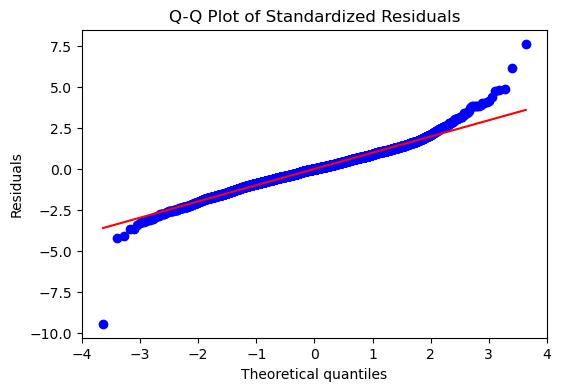

In [ ]:
influence = reg_step.get_influence()
red_resid = influence.resid_studentized_internal 
## Check Normality
# Generate a Q-Q plot
plt.figure(figsize=(6, 4))
stats.probplot(red_resid, dist="norm", plot=plt)
plt.title("Q-Q Plot of Standardized Residuals")
plt.ylabel("Residuals")
plt.show()

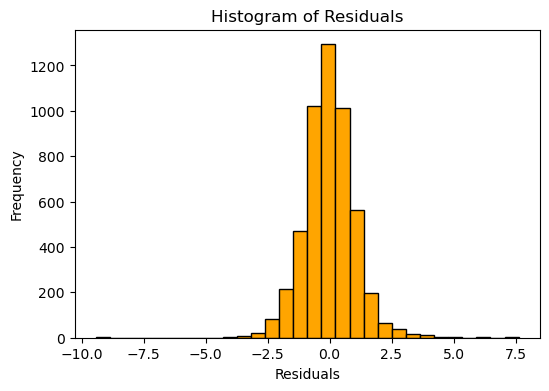

In [ ]:
# Plot histogram of residuals
plt.figure(figsize=(6, 4))
plt.hist(red_resid, bins=30, color='orange', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

The plots show the shape of the distribution of the residuals and that the distribution is symmetric, but with heavy tails similar to the full model.

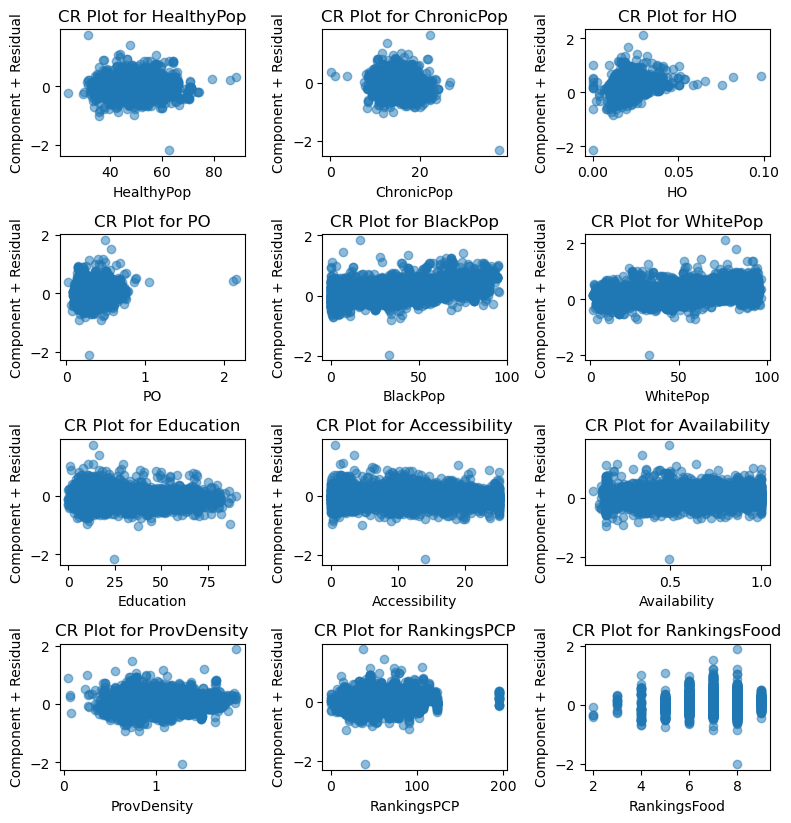

In [ ]:
## Check Linearity

# Get predictor variable names, excluding the intercept and categorical predictors
predictor_vars = [var for var in reg_step.model.exog_names if var not in ['Intercept', 'State_AR', 'State_LA', 'State_NC', 'Urbanicity_Urban', 'Urbanicity_Suburban']]

# Number of rows and columns for subplots
n = len(reg_step.model.exog_names)
ncols = 3
nrows = n // ncols + (n % ncols > 0)

# Create subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(8, 2 * nrows))
axs = axs.flatten()  # Flatten to 1D array for easy indexing

# Generate CR Plot for each predictor
for i, var in enumerate(predictor_vars):
    # Calculate component plus residual values
    exog_idx = reg_step.model.exog_names.index(var)
    partial_resid = reg_step.resid + reg_step.model.exog[:, exog_idx] * reg_step.params[var]

    # Plot
    axs[i].scatter(reg_step.model.exog[:, exog_idx], partial_resid, alpha=0.5)
    axs[i].set_xlabel(var)
    axs[i].set_ylabel('Component + Residual')
    axs[i].set_title(f'CR Plot for {var}')

# Hide unused subplots if any
for j in range(i + 1, nrows * ncols):
    axs[j].set_visible(False)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

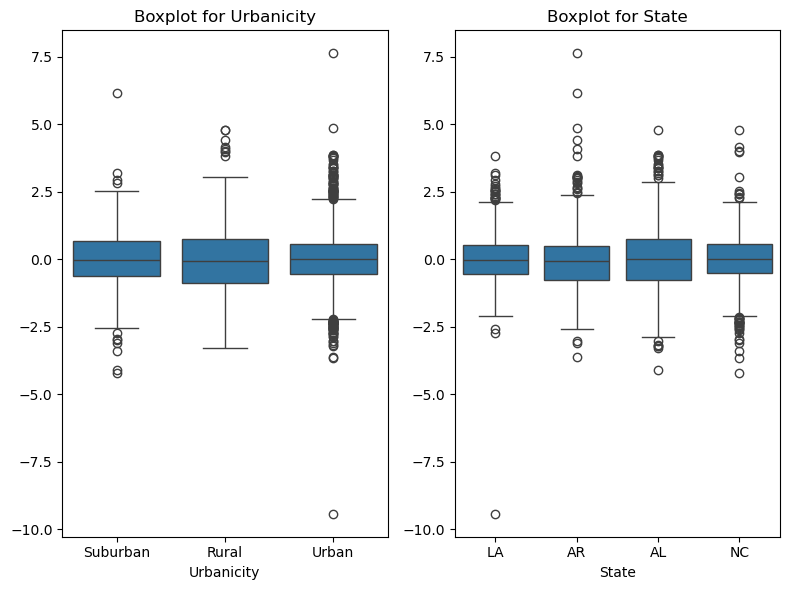

In [ ]:
# Now, plot the boxplots for 'Urbanicity' and 'State'
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

# Boxplot for 'Urbanicity'
sns.boxplot(x= dataAdult['Urbanicity'], y= red_resid, ax=axs[0])
axs[0].set_title('Boxplot for Urbanicity')

# Boxplot for 'State'
sns.boxplot(x= dataAdult['State'], y= red_resid, ax=axs[1])
axs[1].set_title('Boxplot for State')

# Show the plots
plt.tight_layout()
plt.show()

There are no substantial differences in the diagnostics for linearity for the selected model versus the full model.

### Removing the outlier

In [ ]:
dataAdult_no_out = dataAdult_red.drop([908])

In [ ]:
y, X = dmatrices(full_formula, data=dataAdult_no_out, return_type='dataframe')
full_no_out = sm.OLS(y, X).fit()

# Backward Stepwise

In [ ]:
backward_features_no_out, _ = backward_selection(y, X, min_X=["Intercept", "HealthyPop", "ChronicPop"], max_X=None)

Selected Features so far:  ['Intercept', 'HealthyPop', 'ChronicPop', 'State_AR', 'State_LA', 'State_NC', 'Urbanicity_Urban', 'HO', 'PO', 'BlackPop', 'WhitePop', 'Unemployment', 'Income', 'Poverty', 'Education', 'Accessibility', 'Availability', 'ProvDensity', 'RankingsPCP', 'RankingsFood', 'RankingsExercise', 'RankingsSocial'] 	 AIC: -480.53568034273303
Selected Features so far:  ['Intercept', 'HealthyPop', 'ChronicPop', 'State_AR', 'State_LA', 'State_NC', 'Urbanicity_Urban', 'HO', 'PO', 'BlackPop', 'WhitePop', 'Unemployment', 'Income', 'Poverty', 'Education', 'Accessibility', 'Availability', 'ProvDensity', 'RankingsPCP', 'RankingsFood', 'RankingsExercise'] 	 AIC: -482.50068601472594
Selected Features so far:  ['Intercept', 'HealthyPop', 'ChronicPop', 'State_AR', 'State_LA', 'State_NC', 'Urbanicity_Urban', 'HO', 'PO', 'BlackPop', 'WhitePop', 'Income', 'Poverty', 'Education', 'Accessibility', 'Availability', 'ProvDensity', 'RankingsPCP', 'RankingsFood', 'RankingsExercise'] 	 AIC: -483.87

In [ ]:
backward_features_no_out

['Intercept',
 'HealthyPop',
 'ChronicPop',
 'State_AR',
 'State_LA',
 'State_NC',
 'Urbanicity_Urban',
 'HO',
 'PO',
 'BlackPop',
 'WhitePop',
 'Education',
 'Accessibility',
 'Availability',
 'ProvDensity',
 'RankingsPCP',
 'RankingsFood']

In [ ]:
# Define the response variable
step_no_out_formula = "log_EDCost_pmpm ~ HealthyPop + ChronicPop + State_AR + State_LA + State_NC + HO + Education + ProvDensity + RankingsPCP + Accessibility + Availability + PO + Urbanicity_Urban + BlackPop + WhitePop + RankingsFood"

# Create the design matrix
y, X = dmatrices(step_no_out_formula, data=dataAdult_no_out, return_type='dataframe')

reg_step_no_out = sm.OLS(y, X).fit()

In [ ]:
reg_step_no_out.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_EDCost_pmpm   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     1777.
Date:                Thu, 22 May 2025   Prob (F-statistic):               0.00
Time:                        22:48:29   Log-Likelihood:                 260.94
No. Observations:                5018   AIC:                            -487.9
Df Residuals:                    5001   BIC:                            -377.0
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.9352      0.099     19.610      0.000       1.742       2.129
HealthyPop           0.0004      0.001      0.485      0.628      -0.001       0.002
ChronicPop          -0.0011      0.002     -0.527      0.599      -0.005       0.003
State_AR             0.9380      0.015     61.466      0.000       0.908       0.968
State_LA             0.8989      0.012     76.509      0.000       0.876       0.922
State_NC             1.4283      0.016     91.797      0.000       1.398       1.459
HO                  11.5416      0.718     16.069      0.000      10.133      12.950
Education           -0.0017      0.000     -7.483      0.000      -0.002      -0.001
ProvDensity          0.0654      0.015      4.237      0.000       0.035       0.096
RankingsPCP          0.0008      0.000      4.835      0.000       0.000       0.001
Accessibility       -0.0019      0.001     -2.698      0.007      -0.003      -0.001
Availability         0.0756      0.019      3.980      0.000       0.038       0.113
PO                   0.1335      0.040      3.359      0.001       0.056       0.211
Urbanicity_Urban     0.0227      0.009      2.438      0.015       0.004       0.041
BlackPop             0.0051      0.001      9.109      0.000       0.004       0.006
WhitePop             0.0044      0.001      8.065      0.000       0.003       0.005
RankingsFood         0.0162      0.004      4.017      0.000       0.008       0.024
==============================================================================
Omnibus:                      354.819   Durbin-Watson:                   0.905
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1120.782
Skew:                           0.340   Prob(JB):                    4.22e-244
Kurtosis:                       5.213   Cond. No.                     2.42e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

There are no large differences when comparing the selected models using backward stepwise regression with versus without the outlier 908. The R-squares remain around 85%. The only difference is that ChronicPop becomes statistically insignificant without the outlier.

### Prediction: Intervention Analysis

Recall one of the policy questions that we started this analysis with: Does improvement in availability of primary care providers reduce the cost of ED care? Based on this analysis, we found that access, particularly the availability measure, is statistically significantly associated to the ED healthcare cost. 

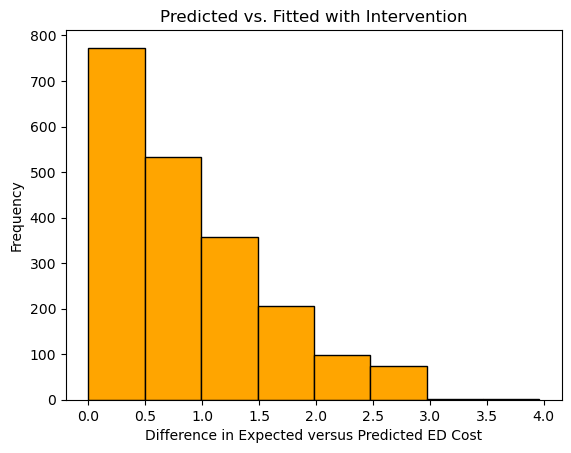

In [ ]:
newdata = X.copy()
index = newdata['Availability'] >= 0.5
# Improve Availability to at most 0.5 congestion experienced by all communities
newdata.loc[newdata['Availability'] >= 0.5, 'Availability'] = 0.5

# Predict by changing Availability with all other predictors fixed
X_new = sm.add_constant(newdata)
EDCost_predict = reg_step_no_out.get_prediction(newdata).predicted_mean

# Compare predicted to fitted for those communities with intervention
fitted_values = np.exp(reg_step_no_out.fittedvalues)
EDCost_diff_fitted = fitted_values - np.exp(EDCost_predict)

# Plotting the histogram for the differences for those communities with intervention
plt.hist(EDCost_diff_fitted[index], color='orange', edgecolor = 'black', bins = 8)
plt.xlabel('Difference in Expected versus Predicted ED Cost')
plt.ylabel('Frequency')
plt.title('Predicted vs. Fitted with Intervention')
plt.show()

To address this question, we will modify the values of the availability predictor while keeping all other variables unchanged. Specifically, for any values of availability greater than 0.5, we will replace them with 0.5. This adjustment simulates an intervention aimed at improving access to primary care in communities where availability is currently above 0.5, effectively reducing congestion and increasing provider availability. By making this change, we assume that these communities experience enhanced primary care access, leading to reduced wait times for appointments. After modifying the availability variable, we will create a new dataset where only this column is updated, while all other variables remain the same.

The histogram shows that the difference is always positive and for some communities the difference in cost is almost $3 per member, per month. For other communities, the difference in the cost is smaller than $1 per member, per month. While this doesn't sound large, if we multiply the cost with 12 to get the cost difference per year, and we multiply that with the number of adults within each census tract, the difference in the cost could be quite large. 

In [ ]:
EDCost_diff_observed = dataAdult['EDCost_pmpm'].drop([908]) - np.exp(EDCost_predict)
EDCost_diff_observed[index].describe()

count    2042.000000
mean        2.226622
std        11.749203
min       -40.680591
25%        -4.713898
50%         0.192353
75%         6.832229
max        83.273604
Name: EDCost_pmpm, dtype: float64

In [ ]:
dataAdult['EDCost_pmpm'].drop([908])

0       58.745108
1       40.963518
2       60.954647
3       58.436191
4       53.415733
          ...    
5014    68.579015
5015    68.567526
5016    42.880127
5017    72.799811
5018    72.801740
Name: EDCost_pmpm, Length: 5018, dtype: float64

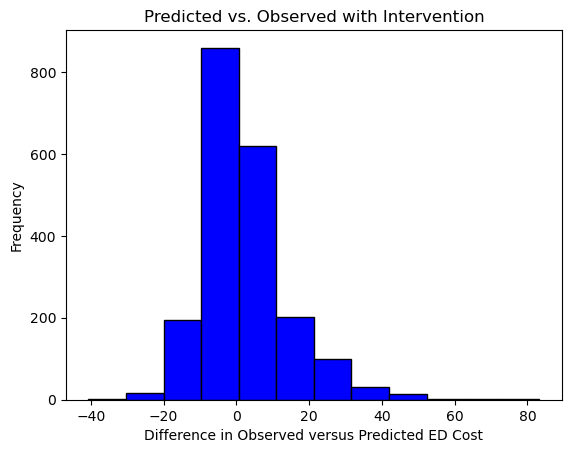

In [ ]:
# Plotting the histogram for the differences for those communities with intervention
plt.hist(EDCost_diff_observed[index], color='blue', edgecolor = 'black', bins = 12)
plt.xlabel('Difference in Observed versus Predicted ED Cost')
plt.ylabel('Frequency')
plt.title('Predicted vs. Observed with Intervention')
plt.show()

We can see from the histogram in blue that we have both positive and negative differences; this is because the observed data are the expected response plus an error term; that error term makes some of the differences to be positive and others negative. We also see that there is a longer tail on the right, on the positive side, which says that there are more communities with a positive difference than with a negative difference.

<Axes: xlabel='State', ylabel='None'>

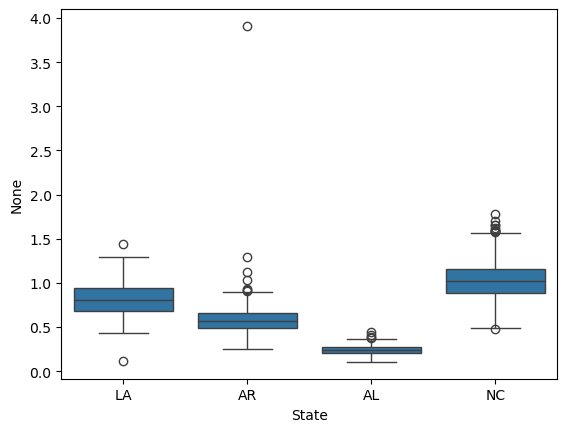

In [ ]:
sns.boxplot(x= dataAdult['State'], y= dataAdult['ED']/dataAdult['PMPM'])

Alabama has the lowest utilization level per adult and North Carolina has the highest utilization

# Testing for subsets of regression coefficients for Urbanicity Factors

In [ ]:
# create a model without Urbanicity factors
dataAdult_less_urban = dataAdult_red.drop(['Urbanicity_Urban', 'Urbanicity_Suburban'], axis = 1)

model_less_urban = sm.OLS(dataAdult_less_urban['log_EDCost_pmpm'], sm.add_constant(dataAdult_less_urban.drop(['log_EDCost_pmpm'], axis = 1))).fit()
model_less_urban.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_EDCost_pmpm   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     1333.
Date:                Thu, 22 May 2025   Prob (F-statistic):               0.00
Time:                        22:48:30   Log-Likelihood:                 219.69
No. Observations:                5019   AIC:                            -395.4
Df Residuals:                    4997   BIC:                            -251.9
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.2019      0.117     18.781      0.000       1.972       2.432
HO                  11.6342      0.757     15.363      0.000      10.150      13.119
PO                   0.1377      0.041      3.392      0.001       0.058       0.217
WhitePop             0.0045      0.001      7.752      0.000       0.003       0.006
BlackPop             0.0050      0.001      8.564      0.000       0.004       0.006
HealthyPop          -0.0007      0.001     -0.807      0.420      -0.002       0.001
ChronicPop          -0.0059      0.002     -2.905      0.004      -0.010      -0.002
Unemployment         0.0005      0.001      0.640      0.522      -0.001       0.002
Income           -2.166e-07   2.77e-07     -0.782      0.434   -7.59e-07    3.26e-07
Poverty             -0.0004      0.000     -0.793      0.428      -0.001       0.001
Education           -0.0015      0.000     -4.522      0.000      -0.002      -0.001
Accessibility       -0.0020      0.001     -2.800      0.005      -0.003      -0.001
Availability         0.0802      0.020      4.061      0.000       0.041       0.119
RankingsPCP          0.0008      0.000      4.352      0.000       0.000       0.001
RankingsFood         0.0060      0.005      1.163      0.245      -0.004       0.016
RankingsHousing     -0.0049      0.002     -3.133      0.002      -0.008      -0.002
RankingsExercise     0.0005      0.000      2.030      0.042     1.6e-05       0.001
RankingsSocial      -0.0011      0.001     -0.820      0.412      -0.004       0.001
ProvDensity          0.0710      0.015      4.777      0.000       0.042       0.100
State_AR             0.9210      0.016     57.845      0.000       0.890       0.952
State_LA             0.9091      0.014     67.038      0.000       0.882       0.936
State_NC             1.4188      0.016     86.200      0.000       1.387       1.451
==============================================================================
Omnibus:                      445.612   Durbin-Watson:                   0.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2666.110
Skew:                           0.179   Prob(JB):                         0.00
Kurtosis:                       6.553   Cond. No.                     1.17e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We explore the impact of urbanicity factor by creating the model without urbanicity and then perform the F-test between full model and model without urbanicity.

In [ ]:
anova_lm(model_less_urban, fullmodel)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,4997.0,269.229456,0.0,NaN,NaN,NaN
1,4995.0,268.983481,2.0,0.245975,2.283865,0.101996


We fail to reject the null hypothesis and cannot show that the model including Urbanicity has explanatory power greater than the model without.

 # Discard all factors that are not statistically significant. Compare models with & without.

In [ ]:
fullmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_EDCost_pmpm   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     1218.
Date:                Thu, 22 May 2025   Prob (F-statistic):               0.00
Time:                        22:48:30   Log-Likelihood:                 221.99
No. Observations:                5019   AIC:                            -396.0
Df Residuals:                    4995   BIC:                            -239.5
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.2075      0.117     18.788      0.000       1.977       2.438
HO                     11.6844      0.759     15.401      0.000      10.197      13.172
PO                      0.1378      0.041      3.350      0.001       0.057       0.218
WhitePop                0.0044      0.001      7.614      0.000       0.003       0.006
BlackPop                0.0049      0.001      8.403      0.000       0.004       0.006
HealthyPop             -0.0009      0.001     -1.108      0.268      -0.003       0.001
ChronicPop             -0.0059      0.002     -2.899      0.004      -0.010      -0.002
Unemployment            0.0004      0.001      0.595      0.552      -0.001       0.002
Income              -2.556e-07   2.77e-07     -0.922      0.357   -7.99e-07    2.88e-07
Poverty                -0.0003      0.000     -0.741      0.459      -0.001       0.001
Education              -0.0014      0.000     -4.390      0.000      -0.002      -0.001
Accessibility          -0.0020      0.001     -2.770      0.006      -0.003      -0.001
Availability            0.0804      0.020      4.068      0.000       0.042       0.119
RankingsPCP             0.0008      0.000      4.175      0.000       0.000       0.001
RankingsFood            0.0066      0.005      1.266      0.206      -0.004       0.017
RankingsHousing        -0.0046      0.002     -2.973      0.003      -0.008      -0.002
RankingsExercise        0.0004      0.000      1.712      0.087   -5.79e-05       0.001
RankingsSocial         -0.0004      0.001     -0.289      0.772      -0.003       0.002
ProvDensity             0.0604      0.016      3.841      0.000       0.030       0.091
State_AR                0.9235      0.016     57.353      0.000       0.892       0.955
State_LA                0.9081      0.014     66.853      0.000       0.881       0.935
State_NC                1.4177      0.017     85.909      0.000       1.385       1.450
Urbanicity_Suburban    -0.0005      0.014     -0.033      0.973      -0.027       0.026
Urbanicity_Urban        0.0207      0.013      1.629      0.103      -0.004       0.046
==============================================================================
Omnibus:                      447.263   Durbin-Watson:                   0.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2664.642
Skew:                           0.185   Prob(JB):                         0.00
Kurtosis:                       6.550   Cond. No.                     1.17e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+07. This might indicate that there are
strong multicollinearity or other numerical problems.

In [ ]:
# Extract the summary dataframe for the coefficients from the model
summary_frame = fullmodel.summary2().tables[1]

# Find predictors that are not statistically significant at alpha = 0.05
not_significant = summary_frame[summary_frame['P>|t|'] > 0.05]

# Extract their p-values
p_values_not_significant = not_significant['P>|t|']

print(p_values_not_significant)


HealthyPop             0.267751
Unemployment           0.551797
Income                 0.356769
Poverty                0.458529
RankingsFood           0.205642
RankingsExercise       0.086907
RankingsSocial         0.772497
Urbanicity_Suburban    0.973406
Urbanicity_Urban       0.103356
Name: P>|t|, dtype: float64


We list the coefficients which are not statistially significant at level of 0.05 according to their p-values.

In [ ]:
data_less_not_stat_sig = dataAdult_red.drop(['HealthyPop', 'Unemployment', 'Income', 'Poverty', 'RankingsFood', 'RankingsExercise', 'RankingsSocial', 'Urbanicity_Suburban', 'Urbanicity_Urban'], axis = 1)
model_less_not_stat_sig = sm.OLS(data_less_not_stat_sig['log_EDCost_pmpm'], sm.add_constant(data_less_not_stat_sig.drop(['log_EDCost_pmpm'], axis = 1))).fit()
model_less_not_stat_sig.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_EDCost_pmpm   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     1997.
Date:                Thu, 22 May 2025   Prob (F-statistic):               0.00
Time:                        22:48:30   Log-Likelihood:                 214.90
No. Observations:                5019   AIC:                            -399.8
Df Residuals:                    5004   BIC:                            -302.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.2324      0.063     35.671      0.000       2.110       2.355
HO                 11.3323      0.737     15.373      0.000       9.887      12.778
PO                  0.1283      0.039      3.248      0.001       0.051       0.206
WhitePop            0.0044      0.001      8.379      0.000       0.003       0.005
BlackPop            0.0048      0.001      9.257      0.000       0.004       0.006
ChronicPop         -0.0060      0.002     -3.486      0.000      -0.009      -0.003
Education          -0.0016      0.000     -6.835      0.000      -0.002      -0.001
Accessibility      -0.0019      0.001     -2.763      0.006      -0.003      -0.001
Availability        0.0691      0.019      3.600      0.000       0.031       0.107
RankingsPCP         0.0009      0.000      5.653      0.000       0.001       0.001
RankingsHousing    -0.0054      0.001     -4.412      0.000      -0.008      -0.003
ProvDensity         0.0727      0.015      4.951      0.000       0.044       0.101
State_AR            0.9249      0.015     61.565      0.000       0.895       0.954
State_LA            0.9236      0.012     76.581      0.000       0.900       0.947
State_NC            1.4330      0.015     97.610      0.000       1.404       1.462
==============================================================================
Omnibus:                      452.398   Durbin-Watson:                   0.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2755.280
Skew:                           0.181   Prob(JB):                         0.00
Kurtosis:                       6.612   Cond. No.                     2.23e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Here we create a new model excluding the above predictors that are not statistically significant
and also exclude GEOID, scaling factor PMPM, and confounding factors EDCost and ED. We exclude OtherPop & ComplexPop because of linear dependence.

In [ ]:
def calculate_mallows_cp(model):
    n = len(model.resid)
    # s_squared = np.var(fullmodel.resid)
    s_squared = np.sum(model.resid ** 2) / (n - len(model.params)) 
    p = len(model.params)
    sse = np.sum(model.resid ** 2)
    cp = (sse / s_squared) - (n - 2 * p)
    return cp

full_model_stats = {
    "Adj R2": fullmodel.rsquared_adj,
    "Mallow's Cp": calculate_mallows_cp(fullmodel),
    "AIC": fullmodel.aic,
    "BIC": fullmodel.bic
}

reduced_model_stats = {
    "Adj R2": model_less_not_stat_sig.rsquared_adj,
    "Mallow's Cp": calculate_mallows_cp(model_less_not_stat_sig),
    "AIC": model_less_not_stat_sig.aic,
    "BIC": model_less_not_stat_sig.bic
}

model_compare = pd.DataFrame({'Full Model': full_model_stats, 'Reduced Model': reduced_model_stats})

model_compare


,Full Model,Reduced Model
Adj R2,0.847949,0.847793
Mallow's Cp,24.000000,15.000000
AIC,-395.975487,-399.797927
BIC,-239.471823,-301.983137


The full model is the preferred model as it has a higher adjusted R-squared value,
lower AIC value, and lower BIC value.

Explore further the three clusters in the data. Can we make up whether spatial dependence based on the latitude & longitude of the centroids of the census tracts?

In the code below, we assign colors to the different states found in our data
and plot the results which clearly shows that our data is clustered by state.

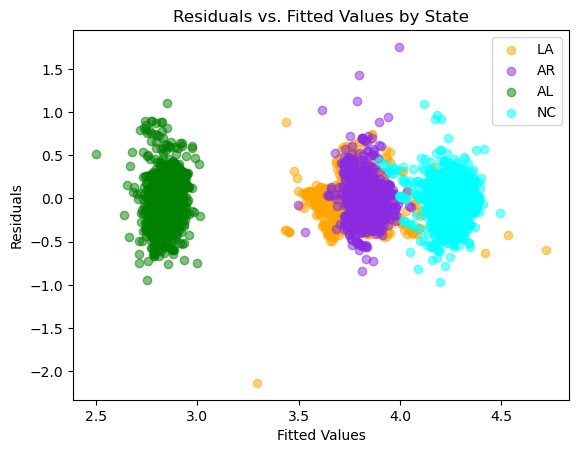

In [ ]:
# Extract fitted values and residuals
fitted_values = full.fittedvalues
residuals = full.resid

# Create a DataFrame with fitted values, residuals, and state
residual_df = pd.DataFrame({
    'fitted': fitted_values,
    'residual': residuals,
    'state': dataAdult['State']
})

# Assign colors based on the state
color_map = {
    'LA': 'orange',
    'AR': 'blueviolet',
    'AL': 'green',
    'NC': 'cyan'
}
residual_df['color'] = residual_df['state'].map(color_map)

# Plot the fitted values vs residuals with colors
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values by State')

for state, color in color_map.items():
    plt.scatter(residual_df[residual_df['state'] == state]['fitted'],
                residual_df[residual_df['state'] == state]['residual'],
                c=color,
                label=state,
                alpha=0.5)

plt.legend()
plt.show()

### Group Lasso

Python and R results differ for group Lasso.

Below, we implement group lasso regression with groupings based on state.

In [ ]:
dataAdult_group = dataAdult.drop(['GEOID', 'EDCost', 'PMPM', 'ED', 'EDCost_pmpm', 'log_EDCost_pmpm'], axis = 1)
dataAdult_group = pd.get_dummies(dataAdult_group, drop_first=True)
dataAdult_group['State_AR'] = dataAdult_group['State_AR'].astype(int)
dataAdult_group['State_LA'] = dataAdult_group['State_LA'].astype(int)
dataAdult_group['State_NC'] = dataAdult_group['State_NC'].astype(int)
dataAdult_group['Urbanicity_Suburban'] = dataAdult_group['Urbanicity_Suburban'].astype(int)
dataAdult_group['Urbanicity_Urban'] = dataAdult_group['Urbanicity_Urban'].astype(int)


In [ ]:
# groups = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 21, 21, 22, 22])
groups = np.array([1, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 14, 14, 15, 15])

The above chunk of code defines the group index for predicting variables. Before that, we assign grouping numbers based on state and urbanicity.

In [ ]:
dataAdult_group.columns

Index(['HO', 'PO', 'WhitePop', 'BlackPop', 'OtherPop', 'HealthyPop',
       'ChronicPop', 'ComplexPop', 'Unemployment', 'Income', 'Poverty',
       'Education', 'Accessibility', 'Availability', 'RankingsPCP',
       'RankingsFood', 'RankingsHousing', 'RankingsExercise', 'RankingsSocial',
       'ProvDensity', 'State_AR', 'State_LA', 'State_NC',
       'Urbanicity_Suburban', 'Urbanicity_Urban'],
      dtype='object')

In [ ]:
predictors = dataAdult_group
response = dataAdult['log_EDCost_pmpm']

scaler = StandardScaler()
predictors_scaled = scaler.fit_transform(predictors)

coefs = []
mean_scores = []
lambdas = np.logspace(-3, 0, 10)
best_lambda = None
best_score = float('inf')

for alpha in lambdas:
    group_lasso = GroupLasso(groups=groups, group_reg=alpha, fit_intercept=True)
    group_lasso.fit(predictors_scaled, response)
    coefs.append(group_lasso.coef_)
    scores = cross_val_score(group_lasso, predictors_scaled, response, cv=10, scoring='neg_mean_squared_error')
    mean_score = -scores.mean()
    mean_scores.append(mean_score)
    if mean_score < best_score:
        best_score = mean_score
        best_lambda = alpha

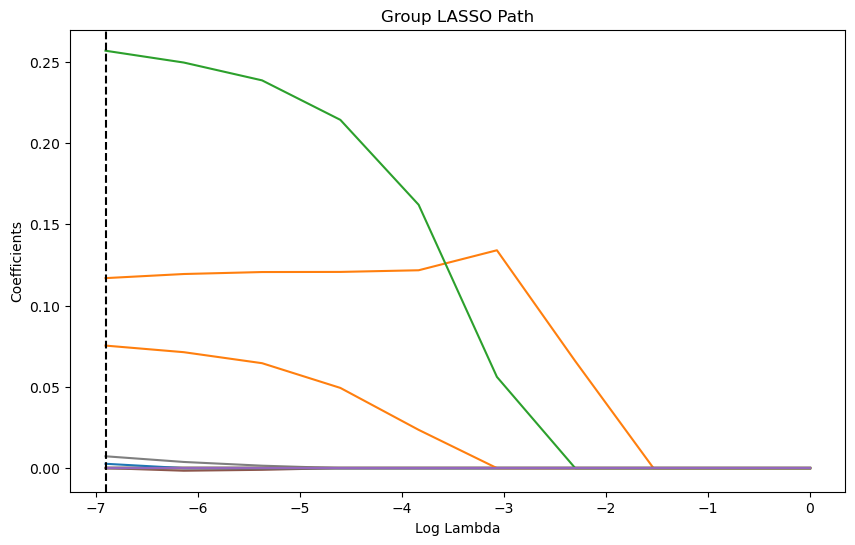

In [ ]:
coefs = np.array(coefs)

plt.figure(figsize=(10, 6))
for i in range(coefs.shape[1]):
    plt.plot(np.log(lambdas), coefs[:, i], label=f'Group {i+1}')

if best_lambda is not None:
    plt.axvline(np.log(best_lambda), linestyle='--', color='black', label='Optimal lambda')

plt.xlabel('Log Lambda')
plt.ylabel('Coefficients')
plt.title('Group LASSO Path')
plt.show()

In [ ]:
final_group_lasso = GroupLasso(groups=groups, group_reg=best_lambda, fit_intercept=True)
final_group_lasso.fit(predictors_scaled, response)

GroupLasso(group_reg=0.001,
           groups=array([ 1,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  7,  8,  9, 10,
       11, 12, 13, 14, 14, 14, 15, 15]))

In [ ]:
group_lasso_results = pd.Series(final_group_lasso.coef_.ravel(), index=dataAdult_group.columns)

In [ ]:
group_lasso_results

HO                     0.000000
PO                     0.116896
WhitePop              -0.000000
BlackPop               0.000000
OtherPop               0.000000
HealthyPop            -0.000000
ChronicPop             0.000000
ComplexPop             0.007301
Unemployment          -0.000000
Income                -0.000000
Poverty                0.000000
Education              0.000000
Accessibility         -0.000000
Availability          -0.000000
RankingsPCP            0.000000
RankingsFood           0.000000
RankingsHousing        0.000000
RankingsExercise       0.000000
RankingsSocial        -0.000000
ProvDensity            0.000000
State_AR               0.002662
State_LA               0.075372
State_NC               0.256776
Urbanicity_Suburban   -0.000000
Urbanicity_Urban       0.000000
dtype: float64

We’re implementing Group LASSO with the group previously defined. Then we apply the grouplasso in order to identify the optimal lambda using 10-fold cross validation. The estimated coefficients are shown above. Coefficients equal to zero indicating that this variable is not selected such as RankingsSocial.

### Apply Group Lasso on Training dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    dataAdult_group, dataAdult['log_EDCost_pmpm'], test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lambdas = np.logspace(-3, 0, 10)
best_lambda = None
best_score = float('inf')

for alpha in lambdas:
    group_lasso = GroupLasso(groups=groups, group_reg=alpha, fit_intercept=True)
    group_lasso.fit(X_train_scaled, y_train)
    scores = cross_val_score(group_lasso, X_train_scaled, y_train, cv=10, scoring='neg_mean_squared_error')
    mean_score = -scores.mean()
    
    if mean_score < best_score:
        best_score = mean_score
        best_lambda = alpha

print(f"Best lambda: {best_lambda}")

final_model = GroupLasso(groups=groups, group_reg=best_lambda, fit_intercept=True)
final_model.fit(X_train_scaled, y_train)

y_pred = final_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

n, p = X_test.shape
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

results_df = pd.DataFrame({
    "Metric": ["MAE", "RMSE", "R²", "Adjusted R²"],
    "Value": [mae, rmse, r2, adj_r2]
})

print(results_df.round(4))

Best lambda: 0.001
        Metric   Value
0          MAE  0.3078
1         RMSE  0.3936
2           R²  0.5475
3  Adjusted R²  0.5359


The above codes are calculating MAE, RMSE, R^2 and Adj_R^2. According to R^2, the Group LASSO model explains ~55% of the variance in the test data. MAE and RMSE are relatively low, suggesting good predictive performance. Meanwhile, the small difference between R^2 and Adj_R^2 indicates that most of the predictors contribute useful information.